# On the consistency and stability of vegetation biophysical variables retrievals from Landsat-8/9 and Sentinel-2 

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
from tqdm import tqdm
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
#import numpy.polynomial.polynomial as poly

### Classes definition

In [2]:
# renames columns of in-situ validation samples to standard names
def renameColumns(siteDF) :  
    if 'CCRS' in os.path.split(os.path.abspath(siteDF.name))[-1]:
        siteDF['network'] = 'CCRS'
        siteDF['NLCD'] = 'MF'
        siteDF.loc[siteDF['BF']>0.75,'NLCD'] = 'DF'
        siteDF.loc[siteDF['BF']<0.25,'NLCD'] = 'EF'
        newNames = {'Location': 'Site', \
                    'PlotID':'PLOT_ID', \
                    'BF' : 'fBroadleaf' , \
                    'NF': 'fNeedleafleaf' , \
                    'fcover_Down': 'fCOVER_down', \
                    'fcover_Up': 'fCOVER_up', \
                    'fcoverstd_Down': 'fCOVER_down_err', \
                    'fcoverstd_Up': 'fCOVER_up_err', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Up': 'fAPAR_up' , \
                    'Daily_Integrated_Black_Sky_fAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sky_fAPAR_Up': 'fAPAR_up' , \
                    'PAICEV61_Up': 'PAI_up', \
                    'PAICEV61_Down': 'PAI_down', \
                    'PAIeCEV61_Up': 'PAIe_up', \
                    'PAIeCEV61_Down':'PAIe_down', \
                    'PAIEMiller_Up': 'PAIe_Miller_up', \
                    'PAIEMiller_Down':'PAIe_Miller_down', \
                    'Woody_Fraction_average':'WAItoPAIratio', \
                    'Woody_Fraction_std': 'WAItoPAIratio_std' }  

    elif 'NEON' in os.path.split(os.path.abspath(siteDF.name))[-1]:
        siteDF['network'] = 'NEON'
        newNames = {'SITE': 'Site', \
                    'PLOT_ID':'PlotID',\
                    'nlcd':'NLCD',\
                    'clumping_index_Miller_understoryest' : 'clumping_Miller_down' , \
                    'clumping_index_Miller_understoryerror': 'clumping_Miller_down_err' , \
                    'clumping_index_Miller_overstoryest': 'clumping_Miller_up', \
                    'clumping_index_Miller_overstoryerror': 'clumping_Miller_up_err', \
                    
                    'clumping_index_Warren_understoryest': 'clumping_Warren_down', \
                    'clumping_index_Warren_understoryerror': 'clumping_Warren_down_err', \
                    'clumping_index_Warren_overstoryest': 'clumping_Warren_up', \
                    'clumping_index_Warren_overstoryerror': 'clumping_Warren_up_err' , \
                    'datetime': 'Date', \
                    'understory_flag': 'down_flag' , \
                    'FIPAR_understoryest': 'fAPAR_down', \
                    'FIPAR_understoryerror': 'fAPAR_down_err', \
                    'FIPAR_overstoryest': 'fAPAR_up', \
                    'FIPAR_overstoryerror':'fAPAR_up_err', \
                    'FCOVER_understoryest': 'fCOVER_down', \
                    'FCOVER_understoryerror':'fCOVER_down_err', \
                    'FCOVER_overstoryest':'fCOVER_up', \
                    'FCOVER_overstoryerror': 'fCOVER_up_err', \
                    
                    'true_LAI_Miller_understoryest':'PAI_Miller_down', \
                    'true_LAI_Miller_understoryerror':'PAI_Miller_down_err', \
                    'true_LAI_Miller_overstoryest':'PAI_Miller_up', \
                    'true_LAI_Miller_overstoryerror':'PAI_Miller_up_err', \
                    'true_LAI_Warren_understoryest':'PAI_Warren_down', \
                    'true_LAI_Warren_understoryerror':'PAI_Warren_down_err', \
                    'true_LAI_Warren_overstoryest':'PAI_Warren_up', \
                    'true_LAI_Warren_overstoryerror':'PAI_Warren_up_err', \
                    
                    'effective_LAI_Miller_understoryest':'PAIe_Miller_down', \
                    'effective_LAI_Miller_understoryerror':'PAIe_Miller_down_err', \
                    'effective_LAI_Miller_overstoryest':'PAIe_Miller_up', \
                    'effective_LAI_Miller_overstoryerror':'PAIe_Miller_up_err', \
                    'effective_LAI_Warren_understoryest':'PAIe_Warren_down', \
                    'effective_LAI_Warren_understoryerror':'PAIe_Warren_down_err', \
                    'effective_LAI_Warren_overstoryest':'PAIe_Warren_up', \
                    'effective_LAI_Warren_overstoryerror':'PAIe_Warren_up_err', \
                    'PLOT_ID':'PLOT_ID', \
                    'timeStart':'timeStart', \
                    'overstory_flag':'up_flag', \
                    'combined_flag':'combined_flag'}
                    
    return  siteDF.rename(columns = newNames)

In [3]:
def rename_nlcd_class (samplesDF) :
    samplesDF.loc[(samplesDF['NLCD'] == 'evergreenForest')            ,'NLCD'] = 'EF'
    samplesDF.loc[ (samplesDF['NLCD'] == 'deciduousForest')           ,'NLCD'] = 'DF' 
    samplesDF.loc[ (samplesDF['NLCD'] == 'mixedForest')               ,'NLCD'] = 'MF'
    samplesDF.loc[ (samplesDF['NLCD'] == 'cultivatedCrops')           ,'NLCD'] = 'CC'
    samplesDF.loc[ (samplesDF['NLCD'] == 'pastureHay')                ,'NLCD'] = 'PH' 
    samplesDF.loc[ (samplesDF['NLCD'] == 'dwarfScrub')                ,'NLCD'] = 'DS'
    samplesDF.loc[ (samplesDF['NLCD'] == 'shrubScrub')                ,'NLCD'] = 'SS' 
    samplesDF.loc[ (samplesDF['NLCD'] == 'woodyWetlands')             ,'NLCD'] = 'WW' 
    samplesDF.loc[ (samplesDF['NLCD'] == 'emergentHerbaceousWetlands'),'NLCD'] = 'EHW'
    samplesDF.loc[ (samplesDF['NLCD'] == 'sedgeHerbaceous')           ,'NLCD'] = 'SH'
    samplesDF.loc[ (samplesDF['NLCD'] == 'grasslandHerbaceous')       ,'NLCD'] = 'GH'
    return (samplesDF) 

In [4]:
def estimateWAItoPAIratio(samplesDF) :
    #estimate overstory woody to total area ratio for NEON sites
    # use initial fixed ratio for all sites based on shrubs 
    
    samplesDF.loc[(samplesDF['network'] == 'NEON') ,'WAItoPAIratio'] = 0.10
    samplesDF.loc[(samplesDF['network'] == 'NEON') ,'WAItoPAIratio_std'] = 0.11
    
    # use fixed ratio for Evergreen Forest
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD'] == 'EF'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD'] == 'EF'),'WAItoPAIratio_std'] = 0.10   
    
    # use fixed ratio for  Deciduous Forest
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD'] == 'DF'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD'] == 'DF'),'WAItoPAIratio_std'] = 0.11
    
    # use fixed ratio for mixed forest
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD'] == 'MF'),'WAItoPAIratio'] = 0.18
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD'] == 'MF'),'WAItoPAIratio_std'] = 0.11

    # use fixed ratio for specific sites# case 2
    samplesDF.loc[(samplesDF['Site'] == 'ABBY')  & (samplesDF['NLCD'] == 'EF'),'WAItoPAIratio'] = 0.70
    samplesDF.loc[(samplesDF['Site'] == 'WREF')  & (samplesDF['NLCD'] == 'EF'),'WAItoPAIratio'] = 0.75
    samplesDF.loc[(samplesDF['Site'] == 'PUUM')  & (samplesDF['NLCD'] == 'EF'),'WAItoPAIratio'] = 0.65
    samplesDF.loc[(samplesDF['Site'] == 'TEAK')  & (samplesDF['NLCD'] == 'EF'),'WAItoPAIratio'] = 0.60

    samplesDF.loc[(samplesDF['Site'] == 'ABBY')  & (samplesDF['NLCD'] == 'EF'),'WAItoPAIratio_std'] = 0.19
    samplesDF.loc[(samplesDF['Site'] == 'WREF')  & (samplesDF['NLCD'] == 'EF'),'WAItoPAIratio_std'] = 0.19
    samplesDF.loc[(samplesDF['Site'] == 'PUUM')  & (samplesDF['NLCD'] == 'EF'),'WAItoPAIratio_std'] = 0.19
    samplesDF.loc[(samplesDF['Site'] == 'TEAK')  & (samplesDF['NLCD'] == 'EF'),'WAItoPAIratio_std'] = 0.19
    return (samplesDF)

In [5]:
def update_RM_outlier_flag(samplesDF0,fnoutliers,variableName):
    outliersDF=data=pd.read_csv(fnoutliers)
    outliers=outliersDF[outliersDF['Variable']==variableName]
    outliers.loc[:,'system:time_start']=pd.to_datetime(outliers['system:time_start'],format='mixed',utc=False).dt.date
    samplesDF0.loc[:,'outlier_flag']=0
    samplesDF0.loc[samplesDF0['network']=='NEON','Date2']=pd.to_datetime(samplesDF0.loc[samplesDF0['network']=='NEON','Date'],format='%d/%m/%Y',utc=False).dt.date
    samplesDF0.loc[samplesDF0['network']=='CCRS','Date2']=pd.to_datetime(samplesDF0.loc[samplesDF0['network']=='CCRS','Date'],format='mixed',utc=False).dt.date
    
    for idx,row in outliers.iterrows():
        samplesDF0.loc[(samplesDF0['PLOT_ID'] == row['PLOT_ID']) & (samplesDF0['Date2'] == row['system:time_start']),'outlier_flag']=1
    print('%s: #outlier: %s'%(variableName, samplesDF0['outlier_flag'].sum()))    
    return samplesDF0

In [6]:
def alaska_site_bias_correction (samples_DF,variableName):
    print ('Alaska_site_bias_correction')
    if variableName=='LAI':
        samples_DF.loc[samples_DF['Site'] == 'BARR','LAI_total'] = samples_DF.loc[samples_DF['Site'] == 'BARR','LAI_total']+0.82
        samples_DF.loc[samples_DF['Site'] == 'TOOL','LAI_total'] = samples_DF.loc[samples_DF['Site'] == 'TOOL','LAI_total']+1.07
        samples_DF.loc[samples_DF['Site'] == 'DEJU','LAI_total'] = samples_DF.loc[samples_DF['Site'] == 'DEJU','LAI_total']+0.60
        
    elif variableName=='fCOVER':
        samples_DF.loc[samples_DF['Site'] == 'BARR','fCOVER_total'] = samples_DF.loc[samples_DF['Site'] == 'BARR','fCOVER_total']+0.27
        samples_DF.loc[samples_DF['Site'] == 'TOOL','fCOVER_total'] = samples_DF.loc[samples_DF['Site'] == 'TOOL','fCOVER_total']+0.34
        samples_DF.loc[samples_DF['Site'] == 'DEJU','fCOVER_total'] = samples_DF.loc[samples_DF['Site'] == 'DEJU','fCOVER_total']+0.18

    elif variableName=='fAPAR':
        samples_DF.loc[samples_DF['Site'] == 'BARR','fAPAR_total'] = samples_DF.loc[samples_DF['Site'] == 'BARR','fAPAR_total']+0.22
        samples_DF.loc[samples_DF['Site'] == 'TOOL','fAPAR_total'] = samples_DF.loc[samples_DF['Site'] == 'TOOL','fAPAR_total']+0.33
        samples_DF.loc[samples_DF['Site'] == 'DEJU','fAPAR_total'] = samples_DF.loc[samples_DF['Site'] == 'DEJU','fAPAR_total']+0.08
    return samples_DF   

In [7]:
def remove_RMs(samplesDF):
    RM=[('OSBS_009','8/9/2021'),
        ('SOAP_058','22/03/2022'),
        ('SOAP_058','19/10/2021'),
        ('SOAP_016','21/06/2018'),
        ('DSNY_015','2/10/2017'),
        ('DSNY_006','19/09/2018')]
    for rm in RM:
        samplesDF.loc[(samplesDF['PLOT_ID']==rm[0])&(samplesDF['Date']==rm[1]),'outlier_flag']=1
        samplesDF.loc[(samplesDF['PLOT_ID']==rm[0])&(samplesDF['Date']==rm[1]),'outlier_flag']=1
    return samplesDF  

In [8]:
def format_features(feat,variablename):
    for key in feat.keys():
        [key1,key2]=list(feat[key][1].keys())
        for idx,row in enumerate(feat[key]):
            row[key1].update({'sample%s'%(variablename):row[key2]})
            feat[key][idx]=row[key1]
    return feat

In [9]:
def parseSampleFile(sampleFileName,variableName,outliersDF=None):
# clumping uncertainty
    clumping_err = 0.025
    WAItoPAIdown= 0.1
    with open(sampleFileName, "rb") as fp:   #Pickling
        sampleDictionary = pickle.load(fp)

    sampleDictionary=format_features(sampleDictionary,variableName)
    sitesList = sampleDictionary.keys()
    samplesDF = pd.DataFrame();
    for key in sitesList:
        #convert list to pandas data frame, rename columns, filter for North America
        siteDF = pd.concat([pd.DataFrame(sampleDictionary[key]),pd.DataFrame([key] * len(sampleDictionary[key]),columns=['geeFeatureCollection'])],axis=1)
        siteDF.name = key
        siteDF = renameColumns(siteDF)
        siteDF=rename_nlcd_class(siteDF)
        siteDF = siteDF[~ siteDF['NLCD'].isin(excluded_NLCD_class)].reset_index()
        
        numValid = []
        numSamples = []
        for index,site in siteDF.iterrows():
            if not site['sample'+variableName].empty:
                siteQC = site['sample'+variableName]['QC'].values
                numSamples.append(len(siteQC))
                numValid.append(len(siteQC) - np.count_nonzero(siteQC))
            else: 
                numSamples.append(0)
                numValid.append(0)
            
        numSamplesDF= pd.DataFrame(numSamples,columns=['numSamples'])
        numValidDF = pd.DataFrame(numValid,columns=['numValid'])
        siteDF = pd.concat([siteDF,numSamplesDF, numValidDF],axis=1)
        samplesDF = pd.concat([samplesDF,siteDF],axis=0,ignore_index=True)
    samplesDF = samplesDF.reset_index(drop=True)
    if outliersDF :
       samplesDF=update_RM_outlier_flag(samplesDF,outliersDF,variableName)
        
    if variableName == 'LAI':     
        pai_algo='Miller' # choices: ['Miller','']
        samplesDF.loc[samplesDF['network'] == 'NEON','PAI_up']       =samplesDF.loc[samplesDF['network'] == 'NEON','PAI_%s_up'%(pai_algo)]
        samplesDF.loc[samplesDF['network'] == 'NEON','PAI_up_err']   =samplesDF.loc[samplesDF['network'] == 'NEON','PAI_%s_up_err'%(pai_algo)] 
        samplesDF.loc[samplesDF['network'] == 'NEON','PAI_down']     =samplesDF.loc[samplesDF['network'] == 'NEON','PAI_%s_down'%(pai_algo)] 
        samplesDF.loc[samplesDF['network'] == 'NEON','PAI_down_err'] =samplesDF.loc[samplesDF['network'] == 'NEON','PAI_%s_down_err'%(pai_algo)] 
        samplesDF.loc[samplesDF['network'] == 'NEON','PAIe_up']       =samplesDF.loc[samplesDF['network'] == 'NEON','PAIe_%s_up'%(pai_algo)]
        samplesDF.loc[samplesDF['network'] == 'NEON','PAIe_up_err']   =samplesDF.loc[samplesDF['network'] == 'NEON','PAIe_%s_up_err'%(pai_algo)] 
        samplesDF.loc[samplesDF['network'] == 'NEON','PAIe_down']     =samplesDF.loc[samplesDF['network'] == 'NEON','PAIe_%s_down'%(pai_algo)] 
        samplesDF.loc[samplesDF['network'] == 'NEON','PAIe_down_err'] =samplesDF.loc[samplesDF['network'] == 'NEON','PAIe_%s_down_err'%(pai_algo)] 

        #samplesDF = estimateWAItoPAIratio(samplesDF)
         # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_up'].mul(0.04830027).add(0.002163865830433743)
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_down'].mul(0.04830027).add(0.002163865830433743)        
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_up'].mul(0.04480655).add(0.010224858872736227)
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_down'].mul(0.04480655).add(0.010224858872736227)

        columns=['PAI_up','PAI_down','PAIe_up','PAIe_down','PAI_up_err','PAI_down_err','PAIe_up_err','PAIe_down_err']
        samplesDF[columns]=correct_cell_values(samplesDF[columns]) #-------------> correct some wrong values 
        samplesDF[columns] = samplesDF[columns].apply(pd.to_numeric)
        samplesDF[columns] = samplesDF[columns].replace(-999, 0)
        samplesDF['percentValid'] = samplesDF['numValid'].div(samplesDF['numSamples'])
        
        # add error due to uncertainty in clumping
        samplesDF['PAI_up_err_clumping'] = samplesDF['PAI_up'].mul(samplesDF['PAI_up'].div((samplesDF['PAIe_up']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_up_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_up_err_clumping'].pow(2)).pow(0.5)
        samplesDF['PAI_down_err_clumping'] = samplesDF['PAI_down'].mul(samplesDF['PAI_down'].div((samplesDF['PAIe_down']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_down_err'] = samplesDF['PAI_down_err'].pow(2).add(samplesDF['PAI_down_err_clumping'].pow(2)).pow(0.5)
         
        #compute total canopy values including woody area
        samplesDF['PAI_total'] = samplesDF['PAI_up'].add(samplesDF['PAI_down']) 
        samplesDF['PAI_total_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_down_err'].pow(2)).pow(0.5)
        samplesDF['PAIe_total'] = samplesDF['PAIe_up'].add(samplesDF['PAIe_down']) 
        samplesDF['PAIe_total_err'] = samplesDF['PAIe_up_err'].pow(2).add(samplesDF['PAIe_down_err'].pow(2)).pow(0.5)
        samplesDF['clumping_total'] = samplesDF['PAIe_total'].div(samplesDF['PAI_total'] ) 
        samplesDF['clumping_total_err']  = (2 * clumping_err  * clumping_err) ** (0.5)    
        
         #compute total canopy values depending to removing woddy area
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF['LAI_up'] = samplesDF['PAI_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_up_err'] = samplesDF['PAI_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_down'] = samplesDF['PAI_down'] * ( 1 - WAItoPAIdown)
        samplesDF['LAI_down_err'] = samplesDF['PAI_down_err'] * ( 1 - WAItoPAIdown)
        samplesDF['LAI_total'] = samplesDF['LAI_up'] + samplesDF['LAI_down']
        samplesDF['LAI_total_err'] = samplesDF['LAI_down_err'].pow(2).add(samplesDF['LAI_up_err'].pow(2)).pow(0.5) 
        
        samplesDF['LAIe_up'] = samplesDF['PAIe_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_up_err'] = samplesDF['PAIe_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_down'] = samplesDF['PAIe_down'] * ( 1 - WAItoPAIdown)
        samplesDF['LAIe_down_err'] = samplesDF['PAIe_down_err'] * ( 1 - WAItoPAIdown)
        samplesDF['LAIe_total'] = samplesDF['LAIe_up'] + samplesDF['LAIe_down']
        samplesDF['LAIe_total_err'] = samplesDF['LAIe_down_err'].pow(2).add(samplesDF['LAIe_up_err'].pow(2)).add(samplesDF['LAI_up'].mul(samplesDF['LAI_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)     

    elif variableName == 'fCOVER' :
        samplesDF = estimateWAItoPAIratio(samplesDF)
        columns=['fCOVER_up','fCOVER_down','fCOVER_up_err','fCOVER_down_err']
        samplesDF[columns]=correct_cell_values(samplesDF[columns]) #-------------> correct some wrong values  
        samplesDF[columns] = samplesDF[columns].apply(pd.to_numeric)
        samplesDF [columns]= samplesDF[columns].replace(-999, 0)
        samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fCOVER_up'] = samplesDF['fCOVER_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fCOVER_down'] = samplesDF['fCOVER_down'] * ( 1 - WAItoPAIdown)
        samplesDF['fCOVER_total'] = samplesDF['fCOVER_up'].add((samplesDF['fCOVER_up'].mul(-1).add(1)).mul(samplesDF['fCOVER_down'] ))
        samplesDF['fCOVER_total_err'] = samplesDF['fCOVER_down_err'].pow(2).add(samplesDF['fCOVER_up_err'].pow(2)).add(samplesDF['fCOVER_up'].mul(samplesDF['fCOVER_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  

    elif  variableName == 'fAPAR' :
        samplesDF = estimateWAItoPAIratio(samplesDF)
        columns=['fAPAR_up','fAPAR_down','fAPAR_up_err','fAPAR_down_err']
        samplesDF[columns]=correct_cell_values(samplesDF[columns]) #-------------> correct some wrong values  
        samplesDF[columns] = samplesDF[columns].apply(pd.to_numeric)
        samplesDF [columns]= samplesDF[columns].replace(-999, 0)
        samplesDF['fAPAR_up'] = samplesDF['fAPAR_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fAPAR_down'] = samplesDF['fAPAR_down'] * ( 1 - WAItoPAIdown)
        samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fAPAR_total'] = samplesDF['fAPAR_up'].add((samplesDF['fAPAR_up'].mul(-1).add(1)).mul(samplesDF['fAPAR_down'] ))
        # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        
        samplesDF['fAPAR_total_err'] = samplesDF['fAPAR_down_err'].pow(2).add(samplesDF['fAPAR_up_err'].pow(2)).add(samplesDF['fAPAR_up'].mul(samplesDF['fAPAR_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  
    else :
        print('variable not found')
    samplesDF= alaska_site_bias_correction (samplesDF,variableName)
    samplesDF=remove_RMs(samplesDF)
    return samplesDF


In [10]:
def correct_cell_values(auxDF):
    nans=auxDF.isnull()
    auxDF=auxDF.astype(str)
    for col in auxDF.columns:
        idx=auxDF[col].str.find('E')
        idx=idx[idx>=1].index
        idx2=auxDF[col].str.find('e')
        idx2=idx2[idx2>=1].index
        for ii in idx:
            base, power =(auxDF.loc[ii][col]).split('E')
            if power=='':
                power='1'
            auxDF.loc[ii,col]=float(base)*(10**float(power))
        for ii in idx2:
            base, power =(auxDF.loc[ii][col]).split('e')
            if power=='':
                power='1'
            auxDF.loc[ii,col]=float(base)*(10**float(power))
        #correct values with 2 . (e.g 0.542.54)  
        idx=auxDF[col].str.count(".")
        for ii in idx[idx>1].index:
            s=auxDF.loc[ii,col].split('.')
            auxDF.loc[ii,col]= s=s[0]+'.'+''.join(s[1:])
 
    auxDF[nans]=np.nan
    auxDF=auxDF.astype(float) 
    return auxDF

In [11]:
def summaryStats(samplesDF,samplesLAIDF,xvariable,yvariable,trimquantile,minPAI):
    estimateMedian = [] 
    estimateSTD = [] 
    medianError = [] 
    estimateCount = [] 
    estimate_max={'LAI':8,'fCOVER':1,'fAPAR':1}

    samplesDF['outlier_flag_total']=(samplesDF['outlier_flag']+samplesLAIDF['outlier_flag']).replace(np.nan,0)
    samplesDF = samplesDF.join(samplesLAIDF[samplesLAIDF.columns.difference(samplesDF.columns)])
    samplesDF = samplesDF[samplesDF['PAI_total']>minPAI]

    for index, sample in samplesDF.iterrows():
        reference = sample[yvariable]
        if 's2cloudless_probability' in sample['sample'+xvariable].columns:  # for Sentinel-2 cloud masking
            sample['sample'+xvariable]=sample['sample'+xvariable].loc[sample['sample'+xvariable]['s2cloudless_probability']<=50]   
        try: 
            qc = sample['sample'+xvariable]['QC']
            estimate = sample['sample'+xvariable]['estimate'+xvariable]
            error = sample['sample'+xvariable]['error'+xvariable]
        except:
            qc = pd.Series()
            estimate = pd.Series()
            error = pd.Series()
         
        productDF = pd.DataFrame(list(zip(qc,estimate,error)),columns=['qc','estimate','error'])
        productDF = productDF.loc[productDF['qc']==0]
        productDF = productDF.loc[productDF['estimate']>=0]
        productDF = productDF.loc[productDF['estimate']<=estimate_max[xvariable]]
        
        if productDF.shape[0]>0 :
            productDF['absresidual'] = (productDF['estimate'] - reference).abs()
            quantileResidual = productDF['absresidual'].quantile(trimquantile/100,interpolation='nearest')
            
            estimateMedian.append(productDF.loc[productDF['absresidual']<=quantileResidual]['estimate'].median())
            estimateSTD.append(productDF.loc[productDF['absresidual']<=quantileResidual,['estimate']].std().divide((productDF.loc[productDF['absresidual']<=quantileResidual].shape[0]) ** (0.5)))
            medianError.append(productDF.loc[productDF['absresidual']==quantileResidual]['error'].median())
            estimateCount.append(productDF.loc[productDF['absresidual']<=quantileResidual].shape[0])
        else:
            estimateMedian.append(np.nan)
            estimateSTD.append(np.nan)
            medianError.append(np.nan)
            estimateCount.append(0)

    samplesDF[xvariable+'_'+yvariable+'_estimate'] = estimateMedian
    samplesDF[xvariable+'_'+yvariable+'_estimate_std'] = estimateSTD 
    samplesDF[xvariable+'_'+yvariable+'_err_estimate_mean'] = medianError
    samplesDF[xvariable+'_'+yvariable+'_estimate_count'] = estimateCount
    return(samplesDF)

In [12]:
def search_input_files(datapath):
    sampleLAIFileName    = os.path.join(datapath,[ff for ff in os.listdir(datapath) if ff.endswith('.pkl') and 'LAI' in ff][0])
    samplefCOVERFileName = os.path.join(datapath,[ff for ff in os.listdir(datapath) if ff.endswith('.pkl') and 'fCOVER' in ff][0])
    samplefAPARFileName  = os.path.join(datapath,[ff for ff in os.listdir(datapath) if ff.endswith('.pkl') and 'fAPAR' in ff][0])
    print('Input files: \nLAI: %s\nfCOVER: %s\nfAPAR: %s: '%(sampleLAIFileName,samplefCOVERFileName,samplefAPARFileName))
    return sampleLAIFileName,samplefCOVERFileName,samplefAPARFileName

In [13]:
def build_samplesList(sampleLAIFileName,samplefAPARFileName,samplefCOVERFileName,p,NEON_RMs_outliers):
    samplesList = []
    sampleLAIparsed=parseSampleFile(sampleLAIFileName,'LAI',NEON_RMs_outliers)
    samplefAPARparsed=parseSampleFile(samplefAPARFileName,'fAPAR',NEON_RMs_outliers)
    samplefCOVERparsed=parseSampleFile(samplefCOVERFileName,'fCOVER',NEON_RMs_outliers)
    samplesLAIDF    = summaryStats(sampleLAIparsed    ,sampleLAIparsed,'LAI'    ,'LAIe_total'  ,p,0.01).reset_index(drop=True) 
    samplesfAPARDF  = summaryStats(samplefAPARparsed  ,sampleLAIparsed,'fAPAR'  ,'fAPAR_total' ,p,0.01).reset_index(drop=True)
    samplesfCOVERDF = summaryStats(samplefCOVERparsed ,sampleLAIparsed,'fCOVER' ,'fCOVER_total',p,0.01).reset_index(drop=True)
    
    samplesDF = samplesfAPARDF[['fAPAR_total','fAPAR_total_err','fAPAR_fAPAR_total_estimate','fAPAR_fAPAR_total_estimate_std','fAPAR_fAPAR_total_err_estimate_mean','fAPAR_fAPAR_total_estimate_count']] \
               .join(samplesfCOVERDF[['fCOVER_total','fCOVER_total_err','fCOVER_fCOVER_total_estimate','fCOVER_fCOVER_total_estimate_std','fCOVER_fCOVER_total_err_estimate_mean','fCOVER_fCOVER_total_estimate_count']])
    
    samplesDF = samplesDF.join(samplesLAIDF[[ff for ff in samplesLAIDF.columns if 'up' not in ff and 'down' not in ff and 'PAI' not in ff]])
    
    outlier_flag=samplesLAIDF['outlier_flag_total']+samplesfAPARDF['outlier_flag_total']+samplesfCOVERDF['outlier_flag_total']
    samplesDF = samplesDF[outlier_flag==0]
    
    samplesDF = samplesDF[samplesDF['LAI_LAIe_total_estimate_count']>0]
    samplesDF = samplesDF[samplesDF['fCOVER_fCOVER_total_estimate_count']>0]
    samplesDF = samplesDF[samplesDF['fAPAR_fAPAR_total_estimate_count']>0]
    samplesDF = samplesDF.dropna(subset='LAI_LAIe_total_estimate')
    samplesDF = samplesDF.dropna(subset='fAPAR_fAPAR_total_estimate')
    samplesDF = samplesDF.dropna(subset='fCOVER_fCOVER_total_estimate')
    samplesList.append(samplesDF)
    print('Done')
    return samplesList

### Initiation

In [14]:
S2_datapath='./data/3_NEON2013_S2_harmonized/2_SL2PV1/'
LS_datapath='./data/2_NEON2013_LS/2_SL2PV1/'
output_path='./0_paper/figures/'

excluded_NLCD_class=['DS']  #Dwarf Scrub
NEON_RMs_outliers='./data/NEON_2013-22_RMs_updated_parsed_outliers.csv'

if not os.path.exists(output_path):
    os.makedirs(output_path)

hue_order=['EHW', 'SH',  'CC', 'PH', 'SS', 'GH','WW', 'MF','DF', 'EF']
palette="tab10"
palette_r="tab10_r"
cmap = ListedColormap(sns.color_palette())
varmax={'LAI':7,'fCOVER':1,'fAPAR':1} 
varstep={'LAI':1,'fCOVER':0.2,'fAPAR':0.2}
errmax1={'LAI':0.20,'fCOVER':0.15,'fAPAR':0.15}  
errmax2={'LAI':1,'fCOVER':0.05,'fAPAR':0.05} 

p=40

## I. Cross-validation SL2P-CCRS/LS and SL2P-CCRS/S2 vs. RMs

### Build SL2P-CCRS / RMs matchapus 

In [15]:
# Browse Sentinel-2 data (.pkl)
sampleLAIFileName,samplefCOVERFileName,samplefAPARFileName=search_input_files(S2_datapath)
samplesListS2=build_samplesList(sampleLAIFileName,samplefAPARFileName,samplefCOVERFileName,p,NEON_RMs_outliers)

Input files: 
LAI: ./data/3_NEON2013_S2_harmonized/2_SL2PV1/NEON_2013-22_RMs_updated_CCRSInSitu2019_COPERNICUS_S2_SR_HARMONIZED_LAI_0_100000_SL2PV1_2024_04_04_12h_04mn.pkl
fCOVER: ./data/3_NEON2013_S2_harmonized/2_SL2PV1/NEON_2013-22_RMs_updated_CCRSInSitu2019_COPERNICUS_S2_SR_HARMONIZED_fCOVER_0_100000_SL2PV1_2024_04_04_12h_04mn.pkl
fAPAR: ./data/3_NEON2013_S2_harmonized/2_SL2PV1/NEON_2013-22_RMs_updated_CCRSInSitu2019_COPERNICUS_S2_SR_HARMONIZED_fAPAR_0_100000_SL2PV1_2024_04_04_13h_04mn.pkl: 
LAI: #outlier: 44.0
Alaska_site_bias_correction
fAPAR: #outlier: 118.0
Alaska_site_bias_correction
fCOVER: #outlier: 137.0
Alaska_site_bias_correction
Done


In [16]:
# Browse Landsat-08/09 data (.pkl)
sampleLAIFileName,samplefCOVERFileName,samplefAPARFileName=search_input_files(LS_datapath)
samplesListLS=build_samplesList(sampleLAIFileName,samplefAPARFileName,samplefCOVERFileName,p,NEON_RMs_outliers)

Input files: 
LAI: ./data/2_NEON2013_LS/2_SL2PV1/NEON_2013-22_RMs_updated_CCRSInSitu2019_LANDSAT_LC08_C02_T1_L2_LAI_0_100000_SL2PV1_2024_04_04_15h_04mn.pkl
fCOVER: ./data/2_NEON2013_LS/2_SL2PV1/NEON_2013-22_RMs_updated_CCRSInSitu2019_LANDSAT_LC08_C02_T1_L2_fCOVER_0_100000_SL2PV1_2024_04_04_15h_04mn.pkl
fAPAR: ./data/2_NEON2013_LS/2_SL2PV1/NEON_2013-22_RMs_updated_CCRSInSitu2019_LANDSAT_LC08_C02_T1_L2_fAPAR_0_100000_SL2PV1_2024_04_04_14h_04mn.pkl: 
LAI: #outlier: 44.0
Alaska_site_bias_correction
fAPAR: #outlier: 118.0
Alaska_site_bias_correction
fCOVER: #outlier: 137.0
Alaska_site_bias_correction
Done


## Analyse data

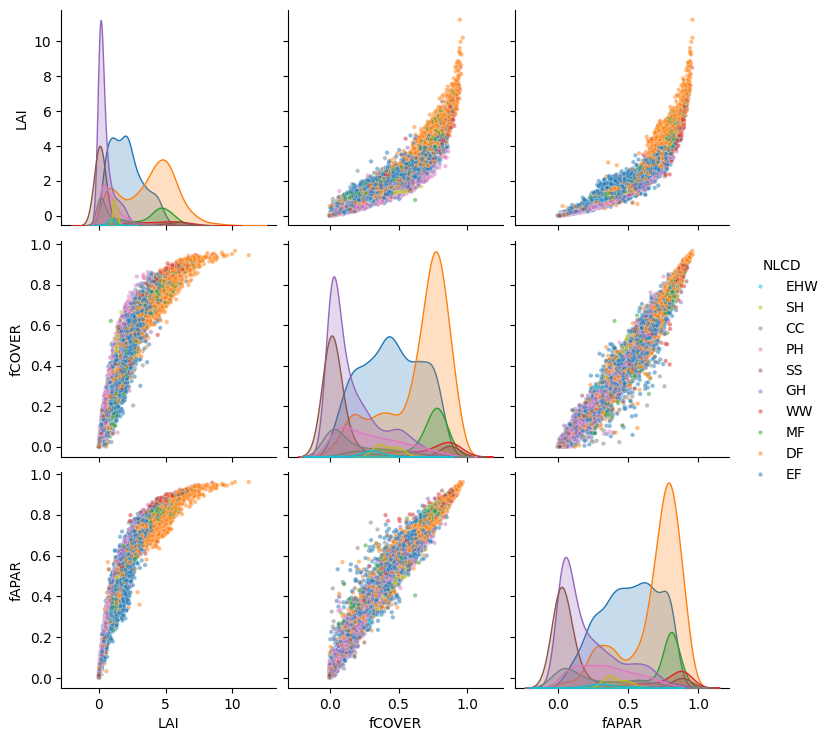

In [20]:
sensor='LS'
samplesDF=eval('samplesList%s[0][:]'%(sensor))
samplesDF = samplesDF.rename(columns={'LAI_total':'LAI','fCOVER_total':'fCOVER','fAPAR_total':'fAPAR'})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','NLCD']]
g = sns.pairplot(samplesDFfig1, hue='NLCD',  hue_order=hue_order,markers= 'o',palette=palette_r,plot_kws={'alpha': 0.50,"s": 10})
plt.savefig(os.path.join(output_path,'0_reference_variables_%s.png'%(sensor)))

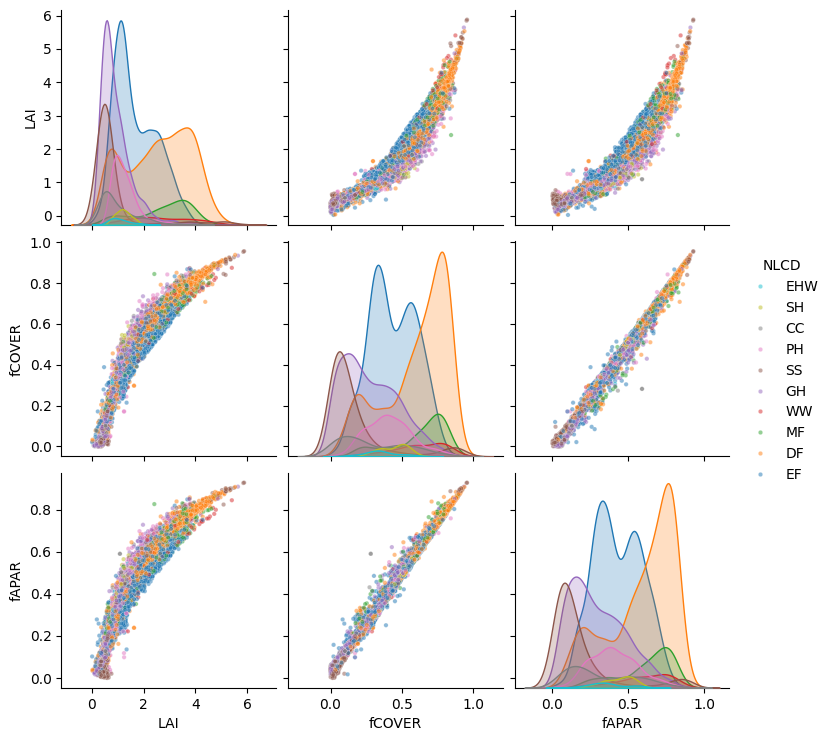

In [21]:
# # sl2p variables by class
samplesDF=eval('samplesList%s[0][:]'%(sensor))
samplesDF = samplesDF.rename(columns={'LAI_LAIe_total_estimate':'LAI','fCOVER_fCOVER_total_estimate':'fCOVER','fAPAR_fAPAR_total_estimate':'fAPAR'})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','NLCD']]
g = sns.pairplot(samplesDFfig1, hue='NLCD', hue_order=hue_order,markers= 'o',palette=palette_r,plot_kws={'alpha': 0.50,"s": 10})
plt.savefig(os.path.join(output_path,'0_sl2p_estimates_%s.png'%(sensor)))

In [22]:
#plot table summurizing available Reference Measurements
samplesDF=parseSampleFile(sampleLAIFileName,'LAI')
samplesDF.loc[samplesDF['network']=='NEON','Date']=pd.to_datetime(samplesDF.loc[samplesDF['network']=='NEON','Date'],format='%d/%m/%Y',utc=False).dt.date
samplesDF.loc[samplesDF['network']=='CCRS','Date']=pd.to_datetime(samplesDF.loc[samplesDF['network']=='CCRS','Date'],format='mixed',utc=False).dt.date
#samplesDF.loc[samplesDF['network'] == 'CCRS','PLOT_ID']      =samplesDF.loc[samplesDF['network'] == 'CCRS','PlotID']
samplesDF=samplesDF[['network','Date','Site','PLOT_ID','NLCD']]
sites=np.unique(samplesDF['Site'])
df=pd.DataFrame()
for site in sites:
    df0=samplesDF[samplesDF['Site']==site].reset_index()
    ESUs=np.unique(df0['PLOT_ID'])
    keys=df0.loc[:,'NLCD'].value_counts()

    nlcd='#'.join(['%s (%s)'%(cc,keys[cc]) for cc in keys.keys()])
    nlcd_domin=keys.keys()[0]
    dict={'Site':site,'Network':df0['network'].values[0],'#ESUs':len(ESUs),'Start Date':min(df0['Date']),'End Date':max(df0['Date']),'#sample':len(df0),'NLCD_domin':nlcd_domin,'NLCD (#sample/NLCD)':nlcd}
    df=df._append(pd.DataFrame([dict]))
   
df=df.loc[df['Network'] == 'CCRS',:].sort_values(by='NLCD_domin')._append(df.loc[df['Network'] == 'NEON',:].sort_values(by='NLCD_domin')).reset_index(drop=True)
df.to_csv(output_path+'/Table_1_used_reference_measures.csv')
print('done') 
df.head()

Alaska_site_bias_correction
done


,Site,Network,#ESUs,Start Date,End Date,#sample,NLCD_domin,NLCD (#sample/NLCD)
0,PeaceRiver2019,CCRS,3,2019-08-12,2019-08-12,3,DF,DF (3)
1,Geraldton2020,CCRS,3,2020-07-21,2020-07-21,3,EF,EF (2)#DF (1)
2,HayRiver2019,CCRS,28,2019-09-05,2019-09-07,28,EF,EF (27)#MF (1)
3,Merbleue2019,CCRS,3,2019-09-18,2019-09-18,3,EF,EF (2)#DF (1)
4,NovaScotia2021,CCRS,3,2021-08-26,2021-08-27,3,EF,EF (2)#DF (1)


### Compare RM / EO dates

In [23]:
# sensor='S2'
# samplesDF=eval('samplesList%s[0][:]'%(sensor))
# samplesDF.loc[samplesDF['network']=='NEON','Date']=pd.to_datetime(samplesDF.loc[samplesDF['network']=='NEON','Date'],format='%d/%m/%Y')
# samplesDF.loc[samplesDF['network']=='CCRS','Date']=pd.to_datetime(samplesDF.loc[samplesDF['network']=='CCRS','Date'],format='mixed')
# df=pd.DataFrame(columns=['network','PLOT_ID','Date','date_min','date_max'])
# for index, sample in samplesDF.iterrows():
#     estimate=sample['sampleLAI']
#     if not estimate.empty:
#         df=df._append(pd.DataFrame([[sample['network'],sample['PLOT_ID'],sample['Date'],estimate['date'].min(),estimate['date'].max()]],columns=df.columns))  
# df=df.reset_index()
# df['date_min'] = pd.to_datetime(df['date_min'], unit='ms')
# df['date_max'] = pd.to_datetime(df['date_max'], unit='ms')
# colname='RM - %s dates difference'%(sensor)
# df[colname]=pd.concat([(df['Date']-df['date_min']).dt.days,(df['Date']-df['date_min']).dt.days],axis=1).max(axis=1)
# sns.histplot(data=df, y=None, x=colname,discrete=True)

## 1. Validate SL2P-CCRS estimates from Landsat-8/9 & Sentinel-2 

### a. Cross-validation

In [24]:
def compute_stats(dfsub,x='x',y='y'):
    n = len(dfsub[x])
    res = np.array(dfsub[y]-dfsub[x])
    unc= np.mean(res ** 2) ** (0.5)
    acc = np.mean(res)
    r2 = np.corrcoef(dfsub[x].astype(float),dfsub[y].astype(float))[0,1]**2
    slope=np.polyfit(dfsub[x].astype(float),dfsub[y].astype(float),1)[0]
    
    return {'N':n,'res':res,'R2':r2,'S':slope,'A':acc,'U':unc,'min_x':dfsub[x].min(),'max_x':dfsub[x].max(),'median_x':dfsub[x].median()}

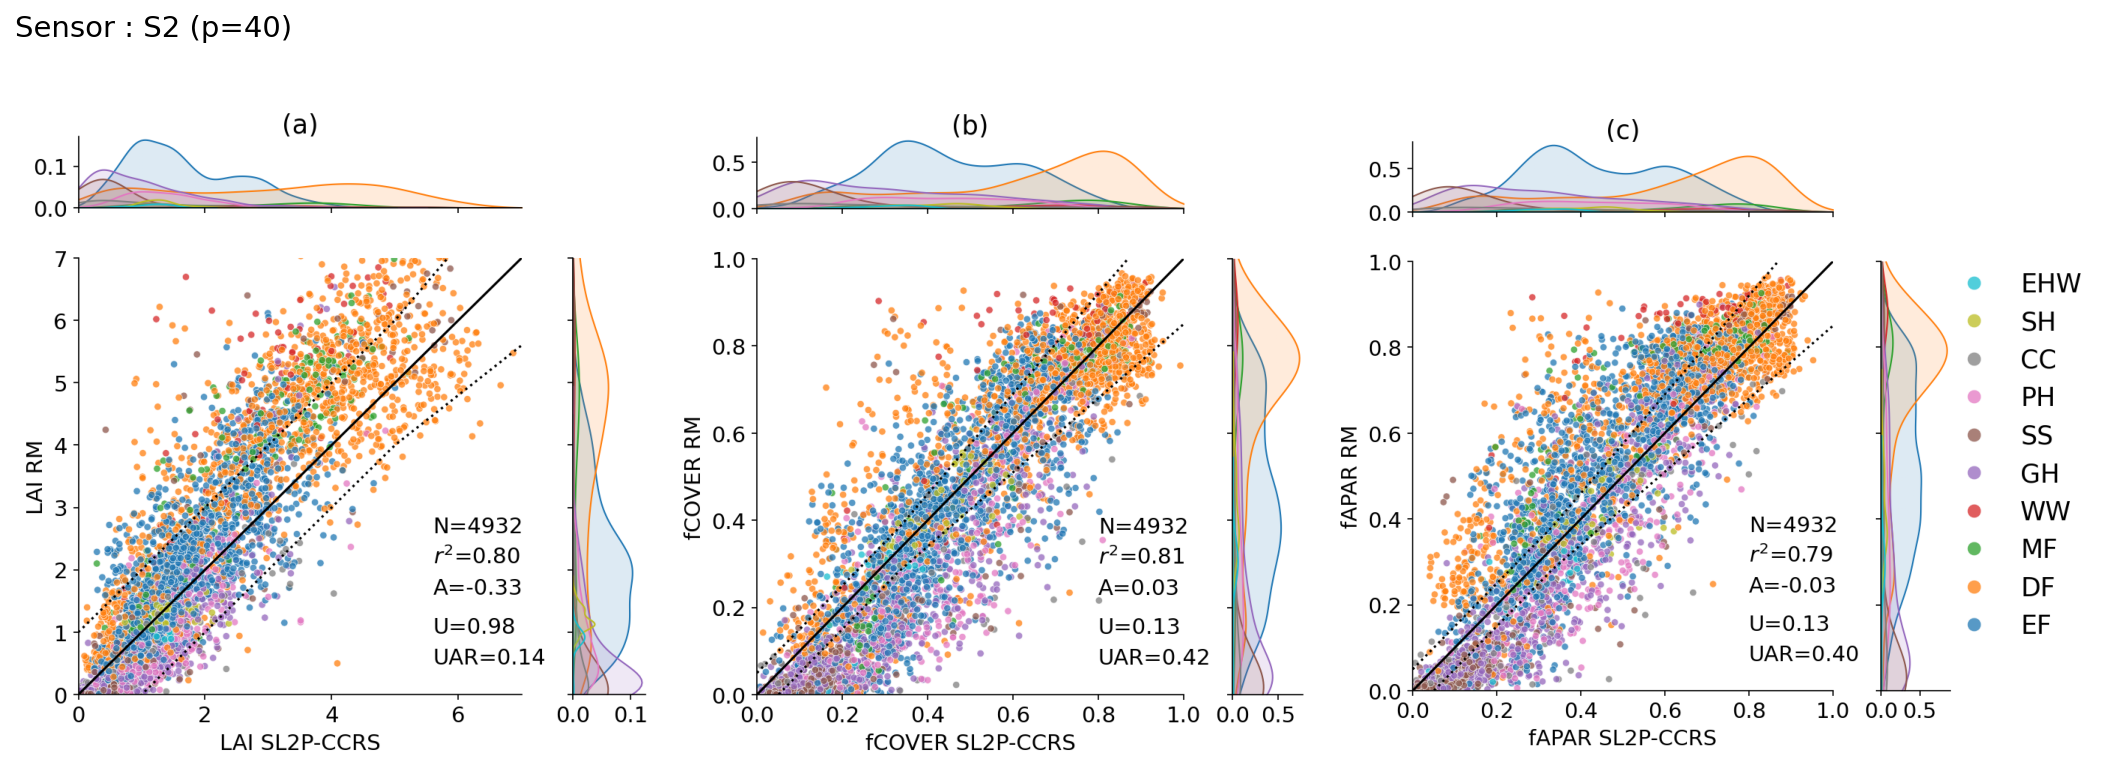

In [75]:
plt.rcParams.update({'font.size': 14})
sensor='S2'
samplesDF=eval('samplesList%s[0][:]'%(sensor))
samplesDF=samplesDF[samplesDF['outlier_flag_total']==0]
fig, ax = plt.subplots(1,3,figsize=(14,6),constrained_layout = True, dpi=150,width_ratios=(1,1,1.2))
ax[0].annotate(f'Sensor : {sensor} (p={p})', xy=(0,1.1), xycoords='axes fraction')

for idx,variableName in enumerate(['LAI','fCOVER','fAPAR']):
    x='%s_%s_total_estimate'%(variableName,variableName)
    y='%s_total'%(variableName)
    if variableName=='LAI':
        x='%s_%se_total_estimate'%(variableName,variableName)
    
    data=samplesDF[:]
 
    g=sns.jointplot(data=data, x=x, y=y, hue='NLCD',hue_order=hue_order,marker='o',alpha=0.75,s=20,palette=palette_r,xlim=[0,varmax[variableName]], ylim=[0,varmax[variableName]],marginal_ticks=True,legend=True,height=6, ratio=4, space=0.7,marginal_kws={'alpha':0.15,'fill':True})
    plt.legend(loc=2, bbox_to_anchor=(1.25,0.5,0, 0.5), borderaxespad=0, frameon=False,markerscale=2, fontsize='large',title_fontsize='large',title='')
       
    plt.plot(np.linspace(0,varmax[variableName],100),np.linspace(0,varmax[variableName],100)+np.maximum(np.linspace(0,varmax[variableName],100)*errmax1[variableName],errmax2[variableName]),color='black',linestyle='dotted')
    plt.plot(np.linspace(0,varmax[variableName],100),np.linspace(0,varmax[variableName],100)+np.minimum(-np.linspace(0,varmax[variableName],100)*errmax1[variableName],-errmax2[variableName]),color='black',linestyle='dotted')
    plt.plot([0,varmax[variableName]],[0,varmax[variableName]],color='black')
    plt.ylabel('%s RM'%(variableName))
    plt.xlabel('%s SL2P-CCRS'%(variableName))
    
    n = len(data[x])
    res = np.array(data[x].sub(data[y]))
    unc= np.mean(res ** 2) ** (0.5)
    acc = np.mean(res)
    r2 = np.corrcoef(data[x],data[y])[0,1]**2

    uar = np.mean(np.abs(res)<np.maximum(0.05,0.10*data[x]))
    plt.annotate(f'N={n}', xy=(0.8, 0.37), xycoords='axes fraction')
    plt.annotate(f'$r^2$={r2:.2f}', xy=(0.8, 0.30), xycoords='axes fraction')
    plt.annotate(f'A={acc:.2f}', xy=(0.8, 0.23), xycoords='axes fraction')
    plt.annotate(f'U={unc:.2f}', xy=(0.8, 0.14), xycoords='axes fraction')
    plt.annotate(f'UAR={uar:.2f}', xy=(0.8, 0.07), xycoords='axes fraction')
    plt.xlim([0,varmax[variableName]])
    plt.ylim([0,varmax[variableName]])
    plt.title('(%s)'%('abcde'[idx]), pad=80)

    fn=os.path.join(output_path,'Figure_2_%s_p%s_2.png'%(sensor,p))
    g.savefig(fn,dpi=150,bbox_inches='tight')
    plt.close(g.fig)
    if variableName=='fAPAR':
        ax[idx].imshow(mpimg.imread(fn))#,extent=(0,0.8,0,0.8)
    else:
        ax[idx].imshow(mpimg.imread(fn)[:,:-188,:])
    [x.set_axis_off() for x in ax.ravel()]
plt.savefig(fn,bbox_inches='tight')
plt.show()

### b. NLCD class specific validation statistics

In [32]:
df=pd.DataFrame(columns=['Sensor','Variable','NLCD','min RM','median RM','max RM','min estimate','median estimate','max estimate','N','R2','A','U','UAR'])
Table_2={}
for sensor in ['LS','S2']:
    samplesDF=eval('samplesList%s[0][:]'%(sensor))
    samplesDF=samplesDF[samplesDF['outlier_flag_total']==0]
    for idx,variableName in enumerate(['LAI','fCOVER','fAPAR']):
        x='%s_%s_total_estimate'%(variableName,variableName)
        y='%s_total'%(variableName)
        if variableName=='LAI':
            x='%s_%se_total_estimate'%(variableName,variableName)
            
        for cover in hue_order+['All']:
            data_s=samplesDF[:]
            if cover in hue_order:
                data_s=data_s[data_s['NLCD']==cover]
            n = len(data_s[x])
            res = np.array(data_s[x].sub(data_s[y]))
            unc= np.mean(res ** 2) ** (0.5)
            acc = np.mean(res)
            r2 = np.corrcoef(data_s[x],data_s[y])[0,1]**2
            uar = np.mean(np.abs(res)<np.maximum(0.05,0.10*data_s[x]))
            data_s[x].min
            df.loc[len(df),:]=[sensor,variableName,cover,data_s[x].min(),data_s[x].median(),data_s[x].max(),data_s[y].min(),data_s[y].median(),data_s[y].max(),n,r2,acc,unc,uar]
                
df['order']=[hue_order.index(elm) if elm in hue_order else 999 for elm in df['NLCD'] ]
df=df.sort_values(by='order',ascending=True)
#df.to_excel(os.path.join(output_path,'Table_2_statists_p%s.xlsx'%(p)))
print('Done')

Done


In [33]:
Table2={}
for sensor in ['LS','S2']:
    Table2[sensor]=pd.DataFrame()
    for variable in ['LAI','fCOVER','fAPAR']:
        if len(Table2[sensor])==0:
            Table2[sensor]=df.loc[(df['Sensor']==sensor)&(df['Variable']==variable),['NLCD']].reset_index(drop=True)
        Table2[sensor]=pd.concat([Table2[sensor],df.loc[(df['Sensor']==sensor)&(df['Variable']==variable),['N','R2','A','U','UAR','min RM','max RM']].add_suffix('_'+variable).reset_index(drop=True)],axis=1)   
    Table2[sensor].to_excel(os.path.join(output_path,'Table_2_statists_%s.xlsx'%(sensor)))  

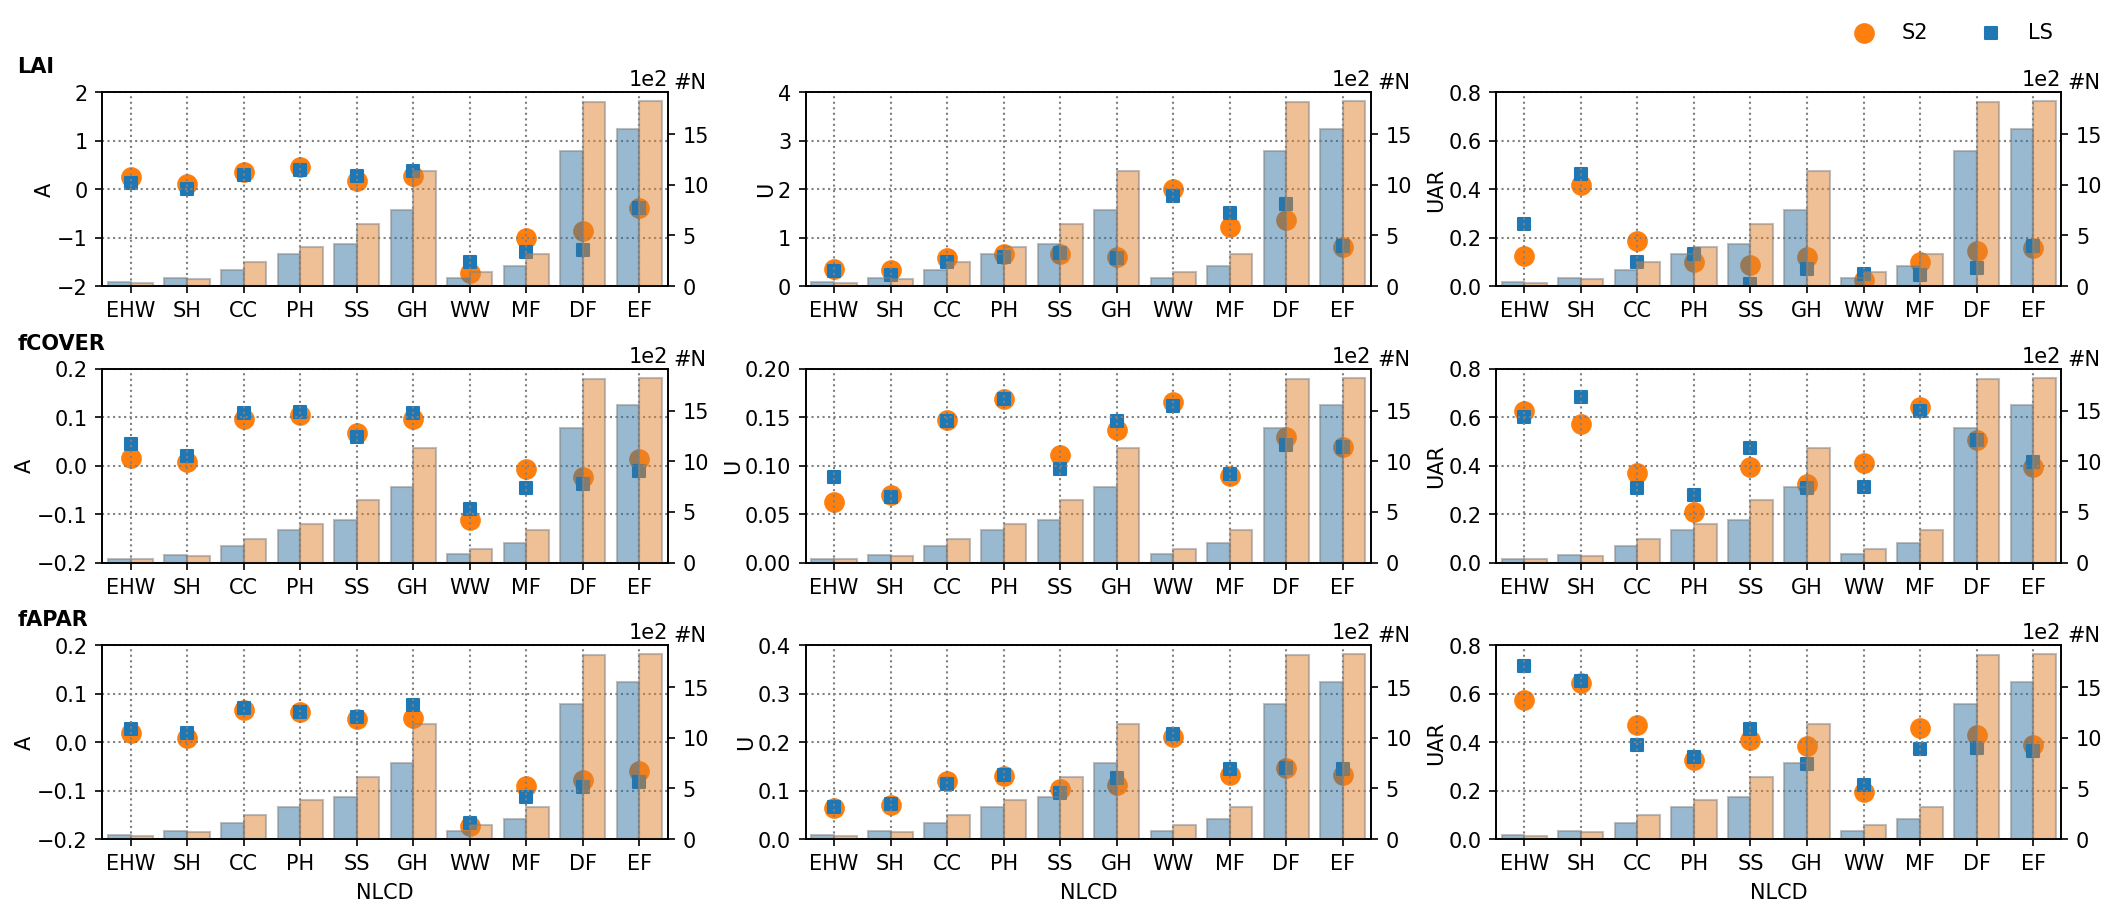

In [34]:
plt.rcParams.update({'font.size':10})
fig, ax = plt.subplots(3,3,figsize=(14,6),constrained_layout = True, dpi=150)
markers=['X','*']
for ii, variableName in enumerate(['LAI','fCOVER','fAPAR']):
    data0=df[df['Variable']==variableName]
    data0=data0[data0['NLCD']!='All']

    ax[ii,0].annotate(f'{variableName}', xy=(-0.15,1.1), xycoords='axes fraction',weight="bold")
    for jj,stat in enumerate(['A','U','UAR']):#['R2','A','U','UAR']
        
        ax1 = ax[ii,jj].twinx()
        data1=data0[data0['Sensor']=='S2'].reset_index()
        data2=data0[data0['Sensor']=='LS'].reset_index()
        
        p0=ax[ii,jj].scatter(data1['NLCD'], data1[stat], marker ="o",color =cmap.colors[1],s = 80,label='S2') 
        p1=ax[ii,jj].scatter(data2['NLCD'], data2[stat], marker ="s",color =cmap.colors[0],s = 30,label='LS') 
        p2=sns.barplot    (data=data0, y='N',  x='NLCD', hue='Sensor',hue_order=['S2','LS'],alpha=0.5,palette=palette,edgecolor=".5", ax=ax1,legend=False)
        
        nbins=4
        if stat!='A':
            ax[ii,jj].set_ylim(bottom=0) 
            ax[ii,jj].locator_params(axis='y', nbins=nbins) 
            xticks=np.round(ax[ii,jj].get_yticks(),nbins)
            ax[ii,jj].set_ylim(top=nbins*xticks[1]) 
            ax[ii,jj].set_yticks(np.arange(0,1.1*nbins*xticks[1],xticks[1]))
        else:
            xmax=max(np.abs(data0[stat]))
            ax[ii,jj].set_ylim([0,xmax])
            ax[ii,jj].locator_params(axis='y', nbins=nbins)
            xticks=np.round(ax[ii,jj].get_yticks(),nbins)
            ax[ii,jj].set_ylim(bottom=-nbins*xticks[1],top=nbins*xticks[1]) 
            
        if variableName=='fAPAR':   
            ax[ii,jj].set_xlabel('NLCD',weight="normal") 
        else:
            ax[ii,jj].set_xlabel('')

        ax1.ticklabel_format(axis='y', style='sci', scilimits=(2,2))
        ax1.set_ylabel('#N', ha='right', y=1.1, rotation=0, labelpad=-1)
        ax[ii,jj].set_ylabel(stat, rotation=90, labelpad=1)
        ax[ii,jj].grid(color='grey', linestyle=':', linewidth=1)  
          
ax[0,2].legend(loc=2,bbox_to_anchor=(0.6,1.4),ncols=2,borderaxespad=0, frameon=False,markerscale=1, fontsize='medium',title_fontsize='medium') # ,title='NLCD')    
plt.savefig(os.path.join(output_path,'Figure_3_statists_by_class_p%s.png'%(p)),bbox_inches='tight')
plt.show()

### d. APU curves

In [35]:
# plots accuracy precision and uncertainty curves based on residuals by fitting a polynomial of specified degree
def plotSummaryStats(x,y,err,axis,ax1,degree,colorlist,sensor=None,marker=None,linewidth=1): #x,y,err,ax[0,0],ax1,3,colorlist,sensor=sensor  
    poly = PolynomialFeatures(degree = degree)
    xp = poly.fit_transform(x.reshape(-1,1))
    accSummary = sm.WLS(y, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    pre = abs(y-np.array(accSummary['mean']))
    preSummary = sm.WLS(pre, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    unc = abs(y)
    uncSummary = sm.WLS(unc, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    if np.max(x)<=1:
        bins=np.arange(0,1.1,0.1)
    else:
        bins=np.arange(0,9,1)
    h=ax1.hist(x,color=colorlist[0],alpha = 0.25,bins=bins,edgecolor='white', linewidth=1.5,label=sensor)
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(2,2))
    ax1.set_ylabel('#N', ha='right', y=1.05, rotation=0, labelpad=0)
    
    idx=[ii for ii in range(0,len(x),1)]
    idx.append(len(x)-1)
    x=np.array([x[ii] for ii in idx])
    accSummary=accSummary.iloc[idx,:].reset_index()
    preSummary=preSummary.iloc[idx,:].reset_index()
    uncSummary=uncSummary.iloc[idx,:].reset_index()

    a=(accSummary['mean']-accSummary['mean_ci_lower'])/np.mean(accSummary['mean'])
    p=(preSummary['mean']-preSummary['mean_ci_lower'])/np.mean(preSummary['mean'])
    u=(uncSummary['mean']-uncSummary['mean_ci_lower'])/np.mean(uncSummary['mean'])
    #print([sensor,round(max(a),2),round(max(p),2),round(max(u),2)])

    
    axis.plot(x, accSummary['mean'], marker=marker,markersize=2,linewidth=linewidth,color=colorlist[1], label='A (%s)'%(sensor))
    axis.plot(x, accSummary['mean_ci_upper'], color=colorlist[1],linewidth=0.5,linestyle='--')
    axis.plot(x, accSummary['mean_ci_lower'],color=colorlist[1],linewidth=0.5,linestyle='--')
    axis.plot(x, preSummary['mean'], marker=marker,markersize=2,linewidth=linewidth,color=colorlist[2], label='P (%s)'%(sensor))
    axis.plot(x, preSummary['mean_ci_upper'], color=colorlist[2],linewidth=0.5,linestyle='--')
    axis.plot(x, preSummary['mean_ci_lower'],color=colorlist[2],linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean'], marker=marker,markersize=2,linewidth=linewidth,color=colorlist[3], label='U (%s)'%(sensor))
    axis.plot(x, uncSummary['mean_ci_upper'], color=colorlist[3],linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean_ci_lower'],color=colorlist[3],linewidth=0.5,linestyle='--')
    return [sensor,accSummary,uncSummary,preSummary]

In [ ]:
# plots accuracy precision and uncertainty curves based on residuals by fitting a polynomial of specified degree
def plotSummaryStats(x,y,err,axis,ax1,degree,colorlist,sensor=None,marker=None,linewidth=1): #x,y,err,ax[0,0],ax1,3,colorlist,sensor=sensor  
    poly = PolynomialFeatures(degree = degree)
    xp = poly.fit_transform(x.reshape(-1,1))
    accSummary = sm.WLS(y, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    pre = abs(y-np.array(accSummary['mean']))
    preSummary = sm.WLS(pre, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    unc = abs(y)
    uncSummary = sm.WLS(unc, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    if np.max(x)<=1:
        bins=np.arange(0,1.1,0.1)
    else:
        bins=np.arange(0,9,1)
    h=ax1.hist(x,color=colorlist[0],alpha = 0.25,bins=bins,edgecolor='white', linewidth=1.5,label=sensor)
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(2,2))
    ax1.set_ylabel('#N', ha='right', y=1.05, rotation=0, labelpad=0)
    
    idx=[ii for ii in range(0,len(x),1)]
    idx.append(len(x)-1)
    x=np.array([x[ii] for ii in idx])
    accSummary=accSummary.iloc[idx,:].reset_index()
    preSummary=preSummary.iloc[idx,:].reset_index()
    uncSummary=uncSummary.iloc[idx,:].reset_index()

    a=(accSummary['mean']-accSummary['mean_ci_lower'])/np.mean(accSummary['mean'])
    p=(preSummary['mean']-preSummary['mean_ci_lower'])/np.mean(preSummary['mean'])
    u=(uncSummary['mean']-uncSummary['mean_ci_lower'])/np.mean(uncSummary['mean'])
    #print([sensor,round(max(a),2),round(max(p),2),round(max(u),2)])

    
    axis.plot(x, accSummary['mean'], marker=marker,markersize=2,linewidth=linewidth,color=colorlist[1], label='A (%s)'%(sensor))
    axis.plot(x, accSummary['mean_ci_upper'], color=colorlist[1],linewidth=0.5,linestyle='--')
    axis.plot(x, accSummary['mean_ci_lower'],color=colorlist[1],linewidth=0.5,linestyle='--')
    axis.plot(x, preSummary['mean'], marker=marker,markersize=2,linewidth=linewidth,color=colorlist[2], label='P (%s)'%(sensor))
    axis.plot(x, preSummary['mean_ci_upper'], color=colorlist[2],linewidth=0.5,linestyle='--')
    axis.plot(x, preSummary['mean_ci_lower'],color=colorlist[2],linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean'], marker=marker,markersize=2,linewidth=linewidth,color=colorlist[3], label='U (%s)'%(sensor))
    axis.plot(x, uncSummary['mean_ci_upper'], color=colorlist[3],linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean_ci_lower'],color=colorlist[3],linewidth=0.5,linestyle='--')
    return [sensor,accSummary,uncSummary,preSummary]

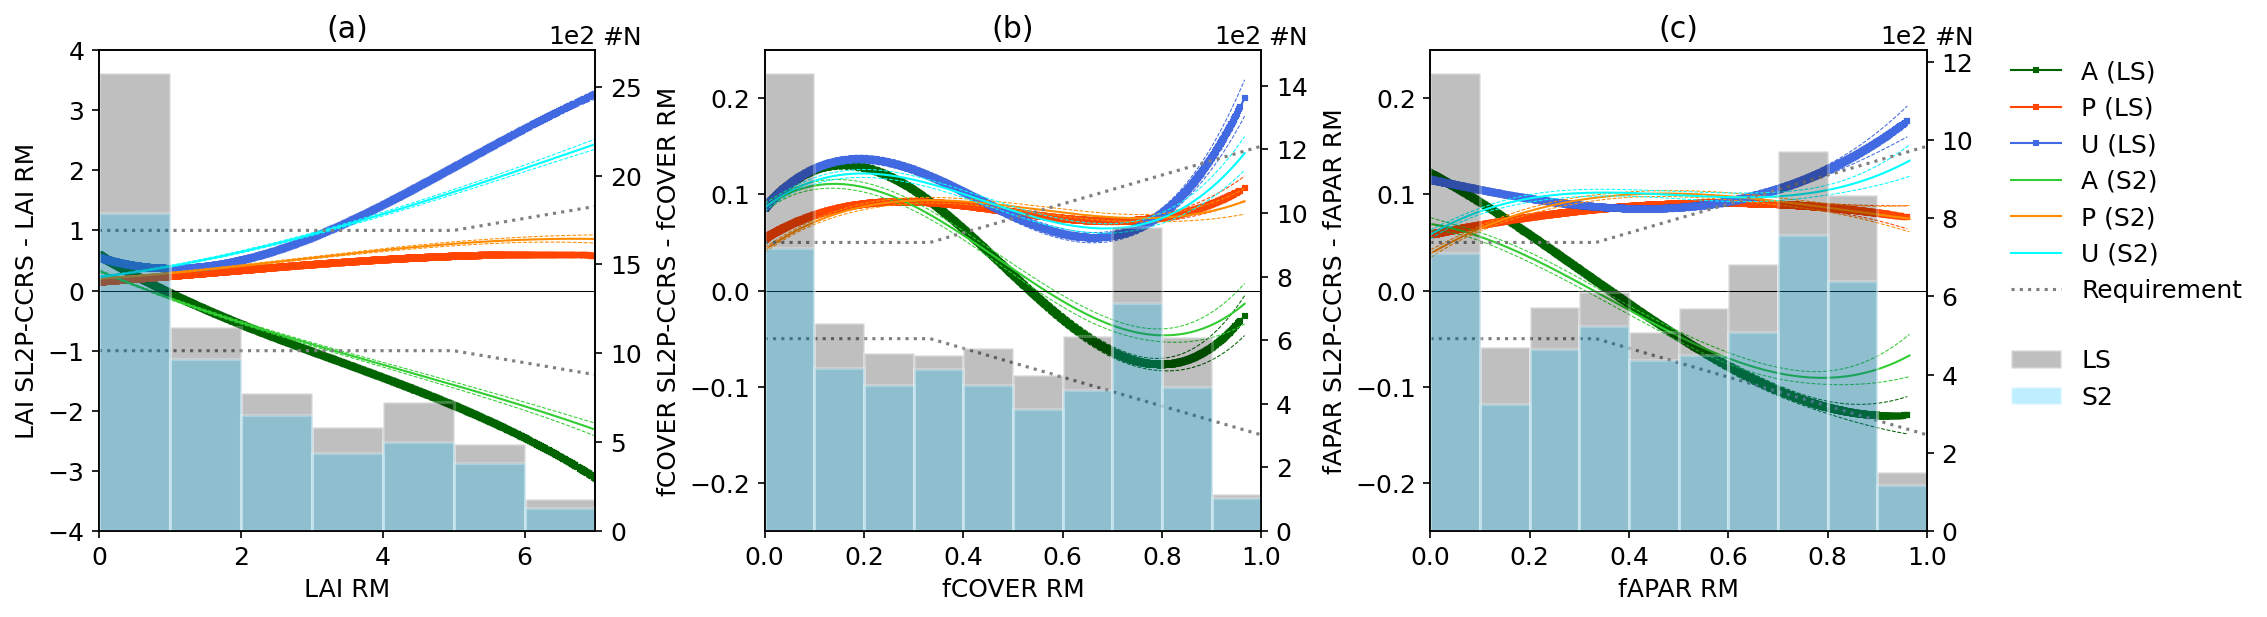

In [80]:
# figure 8
forested=5
percentileToPlot = 0
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(1,3,figsize=(15,4),constrained_layout = True,dpi=150)
yvarmax={'LAI':4,'fCOVER':0.25,'fAPAR':0.25}
colorlist=[['black','darkgreen','orangered','royalblue'],['deepskyblue','limegreen','darkorange','cyan']]
markers=['s','None']
linewidths=[1,1]

for idx,variableName in enumerate(['LAI','fCOVER','fAPAR']):
    ax1 = ax[idx].twinx()
    xc='%s_%s_total_estimate'%(variableName,variableName)
    yc='%s_total'%(variableName)
    if variableName=='LAI':
        xc='%s_%se_total_estimate'%(variableName,variableName)
    xc_err=xc.replace('_total','_total_err')+'_mean'
    yc_err=yc.replace('_total','_total_err')

    for idxs,sensor in enumerate(['LS','S2']):
        data=eval('samplesList%s[percentileToPlot][:]'%(sensor))
        if forested==1:
            data=data[data['NLCD'].isin(['EF','DF','MF','WW'])]
            suffix='forested'
        elif forested==0:
            data=data[~data['NLCD'].isin(['EF','DF','MF','WW'])]
            suffix='unforested'
        else:
            suffix='all'
            
        data = data[~data[xc].isnull()].reset_index()
        randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
        data[yc] = data[yc].add(randomDF['randomCol'])
        data = data.sort_values(yc)
        data['residual'] = data[xc].sub((data[yc]))
        y = np.array(data['residual'])
        x = np.array(data[yc])
        err =np.array(((data[xc_err]).pow(2).add((data[yc_err]).pow(2))).pow(0.5))
        plotSummaryStats(x,y,err,ax[idx],ax1,3,colorlist[idxs],sensor=sensor,linewidth=linewidths[idxs],marker=markers[idxs])
        
    ax[idx].plot(np.linspace(0,varmax[variableName],100),np.maximum(np.linspace(0,varmax[variableName],100) *errmax1[variableName], errmax2[variableName]),color='grey',linestyle='dotted',label='Requirement')
    ax[idx].plot(np.linspace(0,varmax[variableName],100),np.minimum(-np.linspace(0,varmax[variableName],100)*errmax1[variableName],-errmax2[variableName]),color='grey',linestyle='dotted')
    
    ax[idx].axhline(y=0,color='black',linewidth=0.5)
    ax[idx].set_ylabel('%s SL2P-CCRS - %s RM'%(variableName,variableName))
    ax[idx].set_xlabel('%s RM'%(variableName))
    ax[idx].set_xlim([0,varmax[variableName]])
    ax[idx].set_ylim([-yvarmax[variableName],yvarmax[variableName]])
    ax[idx].set_title('(%s)'%('abcde'[idx])) 

ax[2].legend(loc=2, bbox_to_anchor=(1.15,0.5,0, 0.5), borderaxespad=0, frameon=False, fontsize='medium',title_fontsize='x-large')   
ax1.legend  (loc=2, bbox_to_anchor=(1.15,-0.1,0, 0.5), borderaxespad=0, frameon=False, fontsize='medium',title_fontsize='x-large')   

plt.savefig(os.path.join(output_path,'Figure_4_APU_curves_p%s_%s.png'%(p,suffix)),bbox_inches='tight')

## II. Temporal stabilty of SL2PV1 estimates

In [67]:
def slope_function(X,Y,CI=95):
    res = stats.linregress(X, Y)
    tinv = lambda p, df: abs(stats.t.ppf(p/2, df)) ## Two-sided inverse Students t-distribution # p - probability, df - degrees of freedom
    ts = tinv(1-(CI/100), len(X)-2)
    txt=f"S (CI) = {res.slope:.2f} ({ts*res.stderr:.2f})"
    return {'slope':res.slope,'intercept':res.intercept,'confidence_interval_on_slope':ts*res.stderr,'txt':txt}

#### a. all cover types

Done


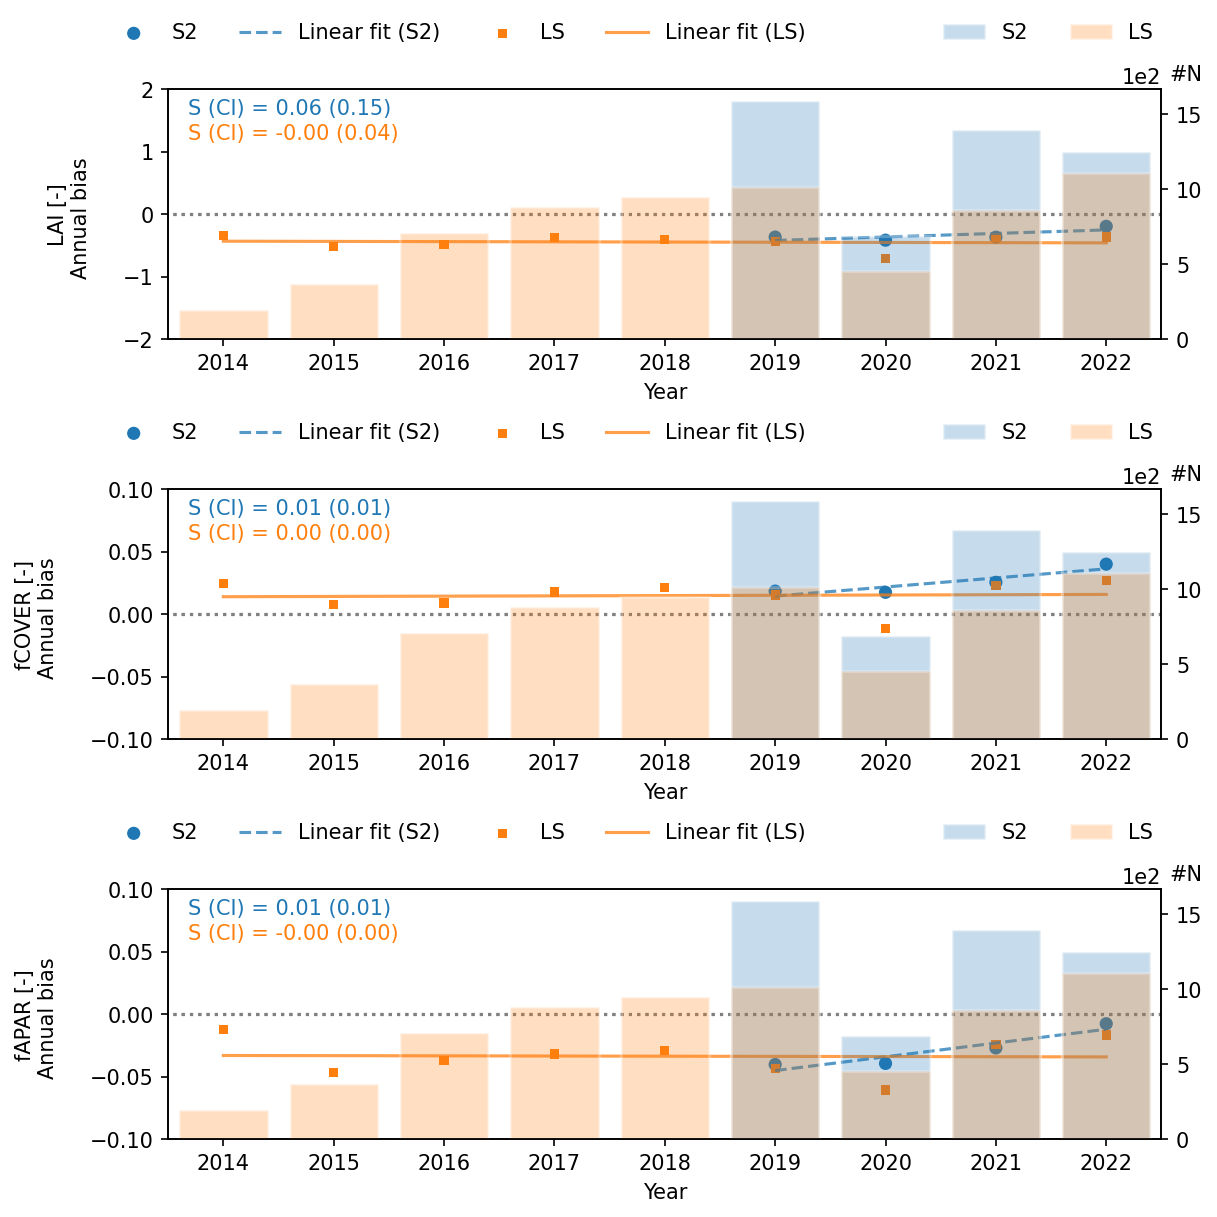

In [68]:
plt.rcParams.update({'font.size':10})
fig, ax = plt.subplots(3,1,figsize=(8,8),constrained_layout = True,dpi=150)
for idx0,variableName in enumerate(['LAI','fCOVER','fAPAR']):
    x='%s_%s_total_estimate'%(variableName,variableName)
    y='%s_total'%(variableName)
    if variableName=='LAI':
        x='%s_%se_total_estimate'%(variableName,variableName)

    ax1= ax[idx0].twinx()
    styleslist=['o','--']
    sizes=[40,20]
    for idx,sensor in enumerate(['S2','LS']):  
        color=cmap.colors[idx]
        samplesDF=eval('samplesList%s[0][:]'%(sensor))
        samplesDF=samplesDF[samplesDF['outlier_flag_total']==0].reset_index()
        samplesDF.loc[samplesDF['network']=='NEON','year']=pd.to_datetime(samplesDF.loc[samplesDF['network']=='NEON','Date'],format='%d/%m/%Y',utc=False).dt.year
        samplesDF.loc[samplesDF['network']=='CCRS','year']=pd.to_datetime(samplesDF.loc[samplesDF['network']=='CCRS','Date'],format='mixed',utc=False).dt.year
        samplesDF=samplesDF[samplesDF['year']>2013]
        if sensor=='S2':
            samplesDF=samplesDF[samplesDF['year']>2018]
              
        samplesDF=samplesDF[['year','network','Site','PLOT_ID','NLCD',x,y]]
        samplesDF.loc[:,'bias'] = samplesDF.loc[:,x]-samplesDF.loc[:,y]
        
        bias=samplesDF[['year','bias']].groupby(['year']).mean().reset_index() 
        bias['count']   =samplesDF[['year','bias']].groupby(['year']).count().reset_index()['bias'] 
        bias['bias_std']=samplesDF[['year','bias']].groupby(['year']).std().reset_index()['bias']
        bias[['network','Site','PLOT_ID','NLCD']]=samplesDF[['network','Site','PLOT_ID','NLCD']].values[:len(bias),:]
        data_s=samplesDF[:]

        ax[idx0].plot(np.linspace(0,2050,100), 0*np.linspace(0,2050,100),linestyle=':',color = 'gray')
        ax[idx0].scatter(bias['year'], bias['bias'],color=color,edgecolors='None',alpha=1,label=sensor,marker=styleslist[0],s=sizes[idx])
        
        if len(bias)>1:
            S=slope_function(bias['year'].values,bias['bias'].values,CI=95)
            ax[idx0].plot(bias['year'],S['slope']*bias['year']+S['intercept'],linestyle=styleslist[1],color=color,alpha=0.75,label='Linear fit (%s)'%(sensor))
            
        ax1.bar(bias['year'], bias['count'],color=color,alpha = 0.25,edgecolor='white', linewidth=1.5,label=sensor)    

        ax[idx0].set_xticks([2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]) 
        ax[idx0].set_xlim([2013.5,2022.5])    
        ax[idx0].set_ylim([-max(1.1*bias['bias'].abs().max(),2*errmax2[variableName]),max(1.1*bias['bias'].abs().max(),2*errmax2[variableName])])
        ax[idx0].annotate(f'{S['txt']}', xy=(0.02, 0.9-idx*0.1), xycoords='axes fraction',color=color)
        styleslist=['s','-']

    ax[idx0].set_ylabel('%s [-]\nAnnual bias \n'%(variableName))
    ax[idx0].set_xlabel('Year')
    ax1.set_ylabel('#N', ha='right', y=1.1, rotation=0, labelpad=0)
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(2,2))
    ax[idx0].legend(loc=1, bbox_to_anchor=(0.65,1,0, 0.3), borderaxespad=0, frameon=False, fontsize='medium',title_fontsize='x-large',ncols=4)    
    ax1.legend     (loc=1, bbox_to_anchor=(1.,1,0, 0.3), borderaxespad=0, frameon=False, fontsize='medium',title_fontsize='x-large',ncols=2)  
plt.savefig(os.path.join(output_path,'Figure_7_bias_temporal_profil_all_sites_p%s.png'%(p)),bbox_inches='tight')
print('Done')    

#### c. site specific

In [72]:
sensor='LS'
min_samples_year=5
min_year={'LS':5,'S2':4}

In [73]:
DF_sites={}
for variableName in ['LAI','fCOVER','fAPAR']:
    output_path0=os.path.join(output_path,'bias_temporal_profile',sensor,variableName,'sites')
    if not os.path.isdir(output_path0):
        os.makedirs(output_path0) 

    x='%s_%s_total_estimate'%(variableName,variableName)
    y='%s_total'%(variableName)
    if variableName=='LAI':
        x='%s_%se_total_estimate'%(variableName,variableName) 
        
    samplesDF=eval('samplesList%s[0][:]'%(sensor))
    samplesDF=samplesDF[samplesDF['outlier_flag_total']==0].reset_index()
    samplesDF.loc[samplesDF['network']=='NEON','year']=pd.to_datetime(samplesDF.loc[samplesDF['network']=='NEON','Date'],format='%d/%m/%Y',utc=False).dt.year
    samplesDF.loc[samplesDF['network']=='CCRS','year']=pd.to_datetime(samplesDF.loc[samplesDF['network']=='CCRS','Date'],format='mixed',utc=False).dt.year
    
    samplesDF=samplesDF[['year','network','Site','PLOT_ID','NLCD',x,y]]
    samplesDF.loc[:,'bias'] = samplesDF.loc[:,x]-samplesDF.loc[:,y]
    samplesDF=samplesDF[np.isfinite(samplesDF['bias'])]
   
    DF_sites.update({variableName:pd.DataFrame(columns=['sensor','variableName','site','NLCD',variableName+'_mean','bias_mean','bias_std','slope','confidence_interval','N'])})
    for site in np.unique(samplesDF['Site']):
        samplesDFS=samplesDF.loc[samplesDF['Site']==site]
        for nlcd in np.unique(samplesDFS['NLCD']):
            samplesDFSN=samplesDFS.loc[samplesDFS['NLCD']==nlcd]

            bias=samplesDFSN[['year',variableName+'_total','bias']].groupby(['year']).mean().reset_index() 
            bias['count']   =samplesDFSN[['year','bias']].groupby(['year']).count().reset_index()['bias'] 
            bias['bias_std']=samplesDFSN[['year','bias']].groupby(['year']).std().reset_index()['bias']
            bias[['network','Site','PLOT_ID','NLCD']]=samplesDFSN[['network','Site','PLOT_ID','NLCD']].values[:len(bias),:]
            bias=bias[bias['count']>=min_samples_year]
            
            if len(bias)>=min_year[sensor]:
                fig, ax = plt.subplots(1,2,figsize=(14,4),constrained_layout = True,width_ratios=[1, 3]) 
                S=slope_function(bias['year'].values,bias['bias'].values,CI=95)

                ax[1].plot(bias['year'],S['slope']*bias['year']+S['intercept'],linestyle='-',color='red')
                bias_mean=bias['bias'].mean()
                #bias_std=bias['bias_std'].mean()
                bias_std=bias['bias'].std()

                sns.scatterplot(data=samplesDFSN, x=x, y=y, alpha=0.75, ax=ax[0],legend=False)
                ax[0].plot(np.linspace(0,varmax[variableName],100),np.linspace(0,varmax[variableName],100)+np.maximum(np.linspace(0,varmax[variableName],100)*errmax1[variableName],errmax2[variableName]),color='black',linestyle='dotted')
                ax[0].plot(np.linspace(0,varmax[variableName],100),np.linspace(0,varmax[variableName],100)+np.minimum(-np.linspace(0,varmax[variableName],100)*errmax1[variableName],-errmax2[variableName]),color='black',linestyle='dotted')
                ax[0].plot([0,varmax[variableName]],[0,varmax[variableName]],color='black')
                
                n = len(samplesDFSN[x])
                res = np.array(samplesDFSN[x].sub(samplesDFSN[y]))
                unc= np.mean(res ** 2) ** (0.5)
                acc = np.mean(res)
                r2 = np.corrcoef(samplesDFSN[x],samplesDFSN[y])[0,1]**2
                ax[0].annotate(f'N={n}', xy=(0.72, 0.25), xycoords='axes fraction',fontsize=8)
                ax[0].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.18), xycoords='axes fraction',fontsize=8)
                ax[0].annotate(f'A={acc:.2f}', xy=(0.72, 0.11), xycoords='axes fraction',fontsize=8)
                ax[0].annotate(f'U={unc:.2f}', xy=(0.72, 0.04), xycoords='axes fraction',fontsize=8)
                ax[0].set(adjustable='box',aspect='equal')
                ax[0].set_ylabel('%s In-Situ'%(variableName))
                ax[0].set_xlabel('%s SL2P'%(variableName))
                ax[0].set_xlim([0,varmax[variableName]])
                ax[0].set_ylim([0,varmax[variableName]])
                
                ax1= ax[1].twinx()
                ax1.bar(bias['year'], bias['count'],alpha=0.50,label='Nsamples')
                ax1.set_ylabel('#N')
                ax1.legend(loc="upper right",bbox_to_anchor=(0.35, 0.99), frameon=False)
                ax[1].plot(np.linspace(0,2050,100), 0*np.linspace(0,2050,100),':k')
                #ax[1].scatter(bias['year'], bias['bias'],label='bias')
                ax[1].errorbar(bias['year'], bias['bias'], yerr=bias['bias_std'], fmt='o',label='Annual bias',capsize=5,color='black')
                ax[1].set_xlim([2013,2023])
                ax[1].set_ylim([-max(1.1*bias['bias'].abs().max(),2*errmax2[variableName]),max(1.1*bias['bias'].abs().max(),2*errmax2[variableName])])
                ax[1].annotate(f'N={bias['count'].sum()}', xy=(0.02, 0.9), xycoords='axes fraction')
                ax[1].annotate(f'{S['txt']}', xy=(0.35, 0.9), xycoords='axes fraction',color='red')
                ax[1].annotate(f'site : {site} - {nlcd} - {sensor}', xy=(0, 1.2), xycoords='axes fraction')
                ax[1].legend(loc="upper right",bbox_to_anchor=(0.22, 0.99), frameon=False,ncol=2)
 
                plt.savefig(os.path.join(output_path0,'5_%s_%s_bias_temporal_profil_p%s.png'%(site,nlcd,p)),bbox_inches='tight')
                plt.close() 

                DF_sites[variableName].loc[len(DF_sites[variableName]),:]=[sensor,variableName,site,nlcd,bias[variableName+'_total'].mean(),bias_mean,bias_std,S['slope'],S['confidence_interval_on_slope'],len(bias)]
print('Done')

Done


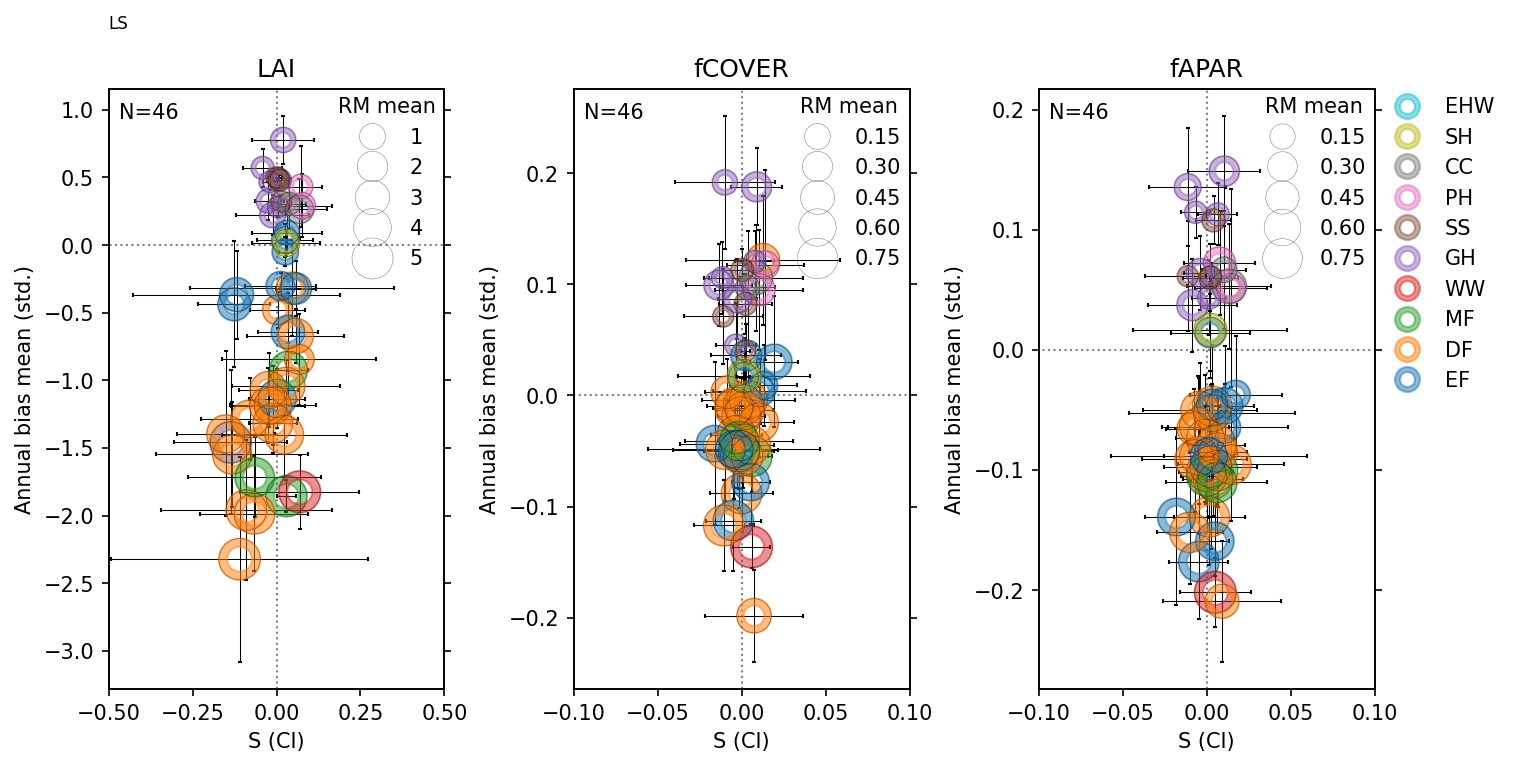

In [74]:
xlim={'LAI':0.5,'fCOVER':0.1,'fAPAR':0.1}
confidence_interval_max={'LAI':0.5,'fCOVER':0.1,'fAPAR':0.1}

plt.style.use(['default'])
fig, ax = plt.subplots(1,3,figsize=(10,5),constrained_layout = True, dpi=150)
for ii,variableName in enumerate(DF_sites.keys()):
    ax1= ax[ii].twinx()
    DF=DF_sites[variableName].rename(columns={"NLCD": "NLCD"})
    DF=DF[DF['confidence_interval']<=confidence_interval_max[variableName]]

    ax[ii].errorbar(DF['slope'], DF['bias_mean'], xerr=DF['confidence_interval'], yerr=DF['bias_std'], fmt='o', markeredgecolor='None', markerfacecolor='None',ecolor = "black",zorder=1,capsize=1,elinewidth=0.5,)
    sns.scatterplot(data=DF, x='slope', y='bias_mean',color='black',size=variableName+"_mean", fc='none',ec='Black',sizes=(100, 400),alpha=0.5,lw=0.25,ax=ax1,legend=True)
    g=sns.scatterplot(data=DF, x='slope', y='bias_mean',hue='NLCD',hue_order=hue_order,palette=palette_r,marker="$\\circ$",linewidth=1,size=variableName+"_mean",ec="face",sizes=(100, 400),alpha=0.5,ax=ax[ii],legend=ii==2)

    ymin, ymax = ax[ii].get_ylim()
    ax[ii].plot([-1000, 1000],[0,0],linestyle=':',color='grey',zorder=0,linewidth=1)
    ax[ii].plot([0,0],[ymin, ymax],linestyle=':',color='grey',zorder=0,linewidth=1)

    ax[ii].set_xlim(-xlim[variableName],xlim[variableName])
    xmin, xmax = ax[ii].get_xlim()
    ax[ii].set_xticks(np.arange(xmin,1.1*xmax,(xmax-xmin)/4))
    ax[ii].set_xlabel('S (CI)')
     
    ax1.set_ylim(ymin, ymax)
    ax1.set_ylabel('')
    ax1.set_yticklabels([])

    ax[ii].set_ylim(ymin, ymax)
    ax[ii].set_ylabel('Annual bias mean (std.)')
    ax[ii].set_title('%s'%(DF['variableName'].values[0]))
    ax[ii].annotate(f'N={len(DF)}', xy=(0.03, 0.95), xycoords='axes fraction')
    h, l = ax[ii].get_legend_handles_labels()
    ax[ii].legend(h[1:11], l[1:11],loc=2,bbox_to_anchor=(1.01,1), borderaxespad=0, frameon=False, ncol=1,fontsize='medium',title_fontsize='medium',markerscale=2,)
    ax1.legend   (loc=1,borderaxespad=0, frameon=False, ncol=1,fontsize='medium',title_fontsize='medium',title='RM mean') 
  
ax[0].annotate(f'{DF['sensor'].values[0]}', xy=(0, 1.1), xycoords='axes fraction',fontsize=8)
plt.savefig(os.path.join(output_path,'Figure_8_bias_slope_analysis_sites_%s.png'%(sensor)),bbox_inches='tight')
plt.show()

## III. Inter-comparison SL2P-CCRS/LS vs SL2P-CCRS/S2

In [81]:
def prepare_data(data,plot_id,var,s2cloudless_probability_threshold=30):
    if (plot_id in data.keys()) & (len(data[plot_id][0]['SL2PV1'])>0):
        out=data[plot_id][0]
        out=out[list(out.keys())[1]][:]
        out=out[out['QC']==0]
        out['date'] = pd.to_datetime(out['date'],unit='ms').dt.date
        out_std=out.groupby(['date']).std().reset_index()
        out=out.groupby(['date']).mean().reset_index() 
        out['estimate_std']=out_std[var]
        out['DOY']=[vv.toordinal() for vv in out['date']]
    else:
        out=pd.DataFrame(columns=[var])
    return out

In [82]:
def read_data (datapath,sensor,variableName,nlcd):
    fn=os.path.join(datapath,[ff for ff in os.listdir(datapath) if nlcd in ff and sensor in ff and variableName in ff and ff.endswith('.pkl')][0])
    with open(fn, "rb") as fp:   #Pickling
        data = pickle.load(fp)
        fp.close()
    return data

In [83]:
def search_y(x,y,dt=1):
    y1=pd.DataFrame(columns=y.columns)
    for idx,dd in enumerate(x['DOY']):
        match=np.argmin(np.abs(y['DOY']-dd))
        if np.abs(dd-y['DOY'][match])<=dt:
            y1.loc[idx,:]=y.loc[match,:]
        else:
            y1.loc[idx,:]=np.nan
    return y1

In [84]:
sensor_dict={'LC08':'LANDSAT','LC09':'LANDSAT','LS':'LANDSAT','HLSL30':'HLS','S2':'COPERNICUS_S2'}
NLCD_groups={'EHW':'Other', 'SH':'Other',  'CC':'Other', 'PH':'Other', 'GH':'Other','SS':'Other', 'WW':'WW','MF':'MF','DF':'DF', 'EF':'EF'}
hue_order_gr=['DF','EF','MF','WW','Other']

inpdir='./data/4_NEON_2013_time_series/SL2PCCRS/'
sensor1='S2'
sensor2='LS'

In [85]:
def compute_stats(dfsub):
    n = len(dfsub.x)
    res = np.array(dfsub.y-dfsub.x)
    unc= np.mean(res ** 2) ** (0.5)
    acc = np.mean(res)
    r2 = np.corrcoef(dfsub.x.astype(float), dfsub.y.astype(float))[0,1]**2
    slope=np.polyfit(dfsub.x.astype(float),dfsub.y.astype(float),1)[0]
    
    return {'N':n,'R2':r2,'S':slope,'A':acc,'U':unc,'min_x':dfsub.x.min(),'max_x':dfsub.x.max(),'median_x':dfsub.x.median()}

In [ ]:
statsdf=pd.DataFrame()
df_variables={}
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(1,3,figsize=(14,4),constrained_layout = True,dpi=150)

for ii,variableName in enumerate(['LAI','fCOVER','fAPAR']):
    datapath=os.path.join(inpdir,variableName)
    df=pd.DataFrame()

    for nlcd in ['cultivatedCrops', 'deciduousForest', 'emergentHerbaceousWetlands', 'evergreenForest', 'grasslandHerbaceous', 'mixedForest', 'pastureHay', 'sedgeHerbaceous', 'shrubScrub', 'woodyWetlands']:#, ,
        data1=read_data (os.path.join(datapath,sensor1),sensor_dict[sensor1],variableName,nlcd)
        data2=read_data (os.path.join(datapath,sensor2),sensor_dict[sensor2],variableName,nlcd)
        dfsub=pd.DataFrame()
        for esu in data1.keys():
            if data1[esu][0]["feature"]["nlcd"]==nlcd:
                x=prepare_data(data1,esu,'estimate'+variableName,s2cloudless_probability_threshold=10)
                y=prepare_data(data2,esu,'estimate'+variableName,s2cloudless_probability_threshold=10)
                
                if len(x)*len(y)>0:
                    y1=search_y(x,y)
                    xerr=x['estimate_std'].values
                    yerr=y1['estimate_std'].values 
                    xunc=x['error'+variableName].values
                    yunc=y1['error'+variableName].values 
                    x=x['estimate'+variableName].values
                    y1=y1['estimate'+variableName].values 
                    dfsub=dfsub._append(pd.DataFrame({'x':x,'y':y1,'xerr':xerr,'yerr':yerr,'xunc':xunc,'yunc':yunc,'Plot_ID':esu,'NLCD':nlcd}))
                    
        dfsub=rename_nlcd_class (dfsub)
        nlcd_class=dfsub['NLCD'].values[0]
        dfsub=dfsub[dfsub['x']>0]
        dfsub=dfsub[dfsub['y']>0].reset_index()

        dfsub['NLCD_GR']= NLCD_groups[nlcd_class] 
        df=df._append(dfsub)
        
        dict={'Variable':variableName,'NLCD':nlcd_class}
        dict.update(compute_stats(dfsub))
        statsdf=statsdf._append(pd.DataFrame([dict]))
        
    dict={'Variable':variableName,'NLCD':'All'}
    dict.update(compute_stats(df))
    statsdf=statsdf._append(pd.DataFrame([dict]))
    
    legend=ii==2
    g=sns.kdeplot(data=df, x="x", y="y",hue="NLCD_GR",hue_order=hue_order_gr,levels=[0.1,0.5], common_norm=False, fill=False,ax=ax[ii],linestyles=[':','-',],palette=palette,legend=legend)# cmap="Reds", alpha= 0.5,,linewidths=[0.5,1],
    ax[ii].plot([0,10],[0,10], 'k:')   
    ax[ii].set_xlabel(f'%s %s'%(variableName,sensor1.replace('C0','')), labelpad=0.5)
    ax[ii].set_ylabel(f'%s %s'%(variableName,sensor2.replace('C0','')), labelpad=0.5)
    ax[ii].set_title(f'(%s)'%('abcdef'[ii]))
    ax[ii].set(adjustable='box',aspect='equal')
    ax[ii].set_xlim([0,varmax[variableName]])
    ax[ii].set_ylim([0,varmax[variableName]])
    ax[ii].set_xticks(np.linspace(0,varmax[variableName],num=int(varmax[variableName]/varstep[variableName])+1))
    ax[ii].set_yticks(np.linspace(0,varmax[variableName],num=int(varmax[variableName]/varstep[variableName])+1))
        
    df_variables[variableName]=df

sns.move_legend(ax[2], loc=2, bbox_to_anchor=(1.,0.5,0, 0.5), borderaxespad=0, frameon=False,markerscale=2, fontsize='medium',title_fontsize='medium',title='')
plt.savefig(os.path.join(outdir,'Figure_5_%s_vs_%s_contours.png'%(sensor1,sensor2)),bbox_inches='tight')                   

In [ ]:
1

In [76]:
statsdf[['R2','S','A', 'U', 'min_x', 'max_x']]=statsdf[['R2','S', 'A', 'U', 'min_x', 'max_x']].round(2)
data=pd.DataFrame()
for variableName in ['LAI','fCOVER','fAPAR']:
    data=pd.concat([data,statsdf[statsdf['Variable']==variableName].drop(['Variable','median_x'],axis=1).add_suffix('_'+variableName)],axis=1)
data.index=[hue_order.index(elm) if elm in hue_order else 999 for elm in data['NLCD_LAI'] ]
data=data.sort_index().drop(['NLCD_fCOVER','NLCD_fAPAR'],axis=1)   
data.to_csv(os.path.join(output_path,'Table_3_statistiques_%s_vs_%s_2.csv'%(sensor1,sensor2)))

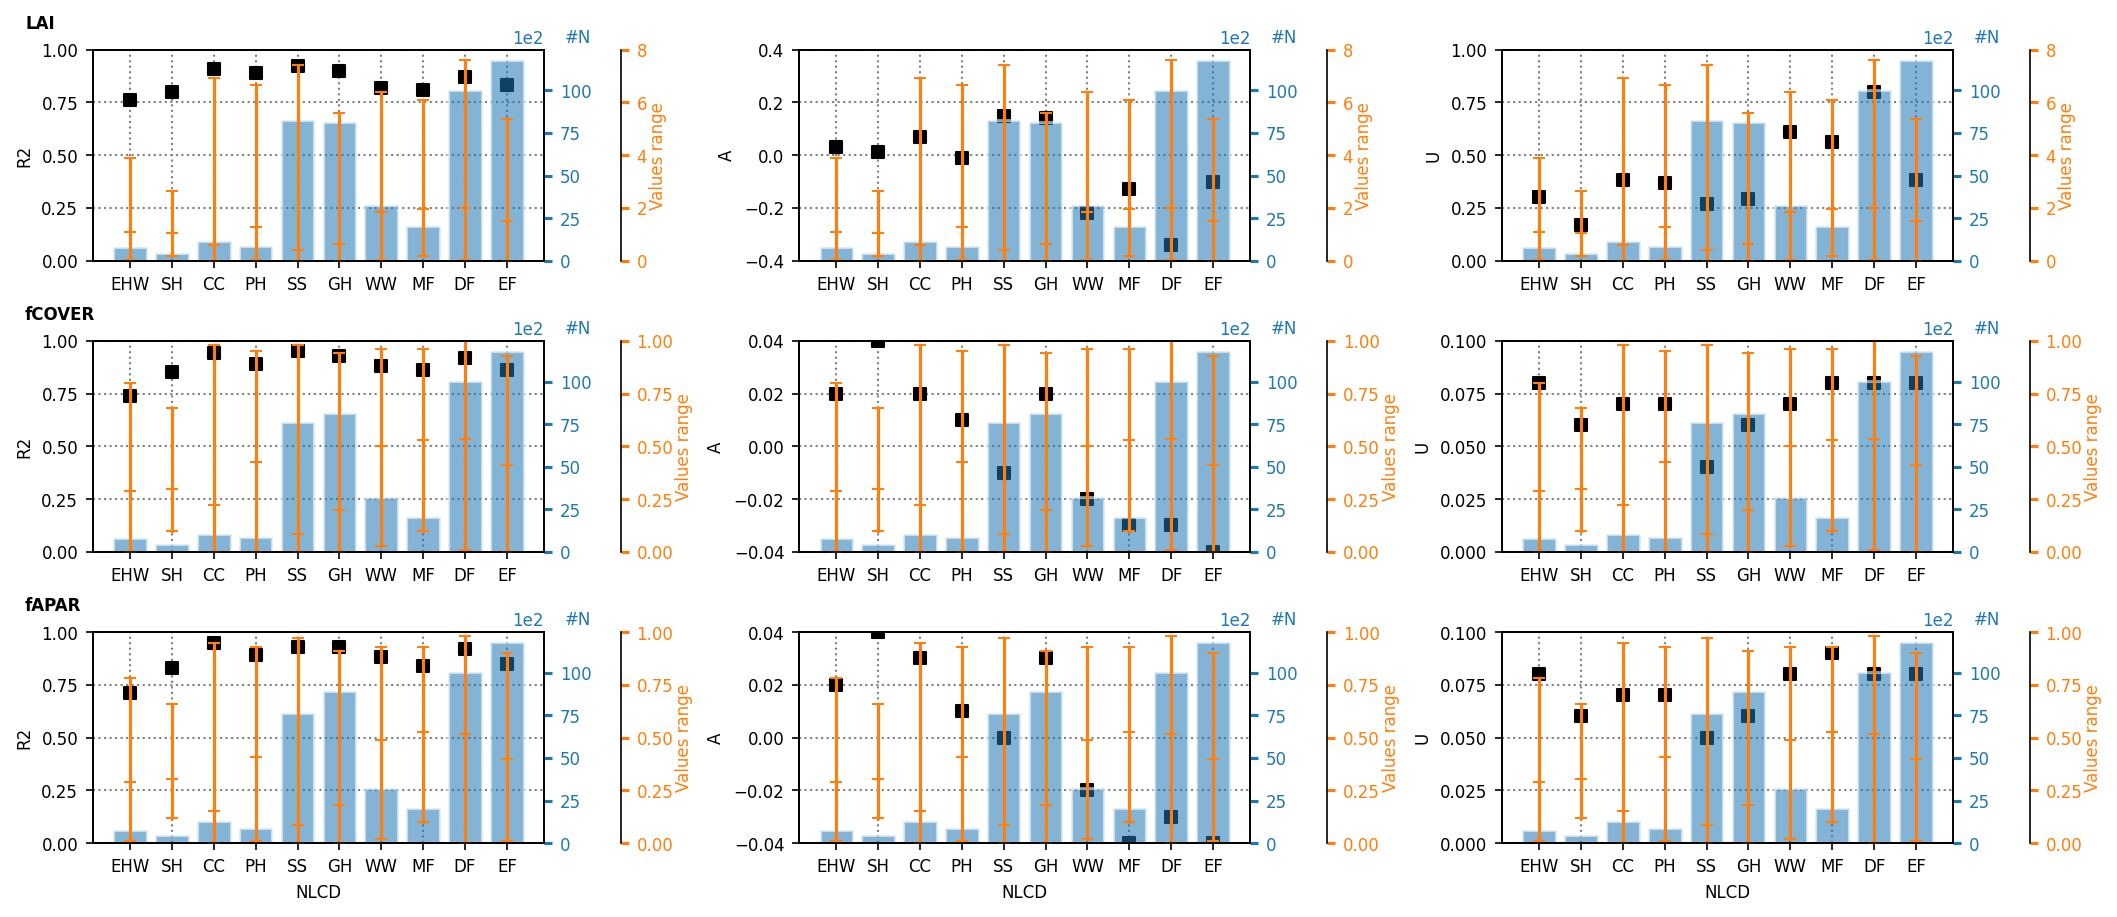

In [78]:
plt.rcParams.update({'font.size':8})
fig, ax = plt.subplots(3,3,figsize=(14,6),constrained_layout = True, dpi=150)

markers=['s','o']
for ii, variableName in enumerate(['LAI','fCOVER','fAPAR']):
    data0=statsdf[statsdf['Variable']==variableName]
    data0=data0[data0['NLCD']!='All']
    data0['order']=[hue_order.index(elm) if elm in hue_order else 999 for elm in data0['NLCD'] ]
    data0=data0.sort_values(by='order',ascending=True).reset_index()

    ax[ii,0].annotate(f'{variableName}', xy=(-0.15,1.1), xycoords='axes fraction',weight="bold")

    for jj,stat in enumerate(['R2','A','U']):#['R2','A','U','UAR']
        ax1 = ax[ii,jj].twinx()
        ax2 = ax[ii,jj].twinx()
        ax2.spines.right.set_position(("axes", 1.17))
 
        p1=ax[ii,jj].scatter (data0['NLCD'], data0[stat], marker ="s",color ='black',s = 30,zorder = 3)
        p2=ax1.bar(data0['NLCD'],data0['N'],color=cmap.colors[0],alpha = 0.55,edgecolor='white', linewidth=1.5,zorder = 1)
        for idx in range(len(data0)):
            ax2.plot([data0['NLCD'][idx],data0['NLCD'][idx],data0['NLCD'][idx]],[data0['min_x'][idx],data0['median_x'][idx],data0['max_x'][idx]],color=cmap.colors[1],linewidth=1.5,marker='_',markersize=6)
            
        if stat!='A':
            nbins=4
            ax[ii,jj].set_ylim(bottom=0) 
            ax[ii,jj].locator_params(axis='y', nbins=nbins) 
            xticks=np.round(ax[ii,jj].get_yticks(),nbins)
            ax[ii,jj].set_ylim(top=nbins*xticks[1]) 
            ax[ii,jj].set_yticks(np.arange(0,1.1*nbins*xticks[1],xticks[1]))
        else:
            xmax=max(np.abs(data0[stat]))
            ax[ii,jj].set_ylim([0,xmax])
            ax[ii,jj].locator_params(axis='y', nbins=nbins)
            xticks=np.round(ax[ii,jj].get_yticks(),nbins)
            ax[ii,jj].set_ylim(bottom=-nbins*xticks[1],top=nbins*xticks[1]) 
            
        if variableName=='fAPAR':   
            ax[ii,jj].set_xlabel('NLCD',weight="normal") 
        else:
            ax[ii,jj].set_xlabel('')
            
        ax[ii,jj].set_ylabel(stat.replace('S','Slope'))
        ax2.set_ylim(0, varmax[variableName])
  
        nbins=4
        ax2.set_ylim(bottom=0) 
        ax2.locator_params(axis='y', nbins=nbins) 
        yticks=np.round(ax2.get_yticks(),nbins)
        ax2.set_ylim(top=nbins*yticks[1]) 
        ax2.set_yticks(np.arange(0,1.1*nbins*yticks[1],yticks[1]))
        
        ax1.tick_params(axis='x',labelsize=8)
        ax1.tick_params(axis='y',labelsize=8)
        ax2.tick_params(axis='x',labelsize=8)
        ax2.tick_params(axis='y',labelsize=8)
        
        ax1.yaxis.label.set_color(cmap.colors[0])
        ax2.yaxis.label.set_color(cmap.colors[1])
        
        tkw = {'size':4, 'width':1.5}
        ax1.tick_params(axis='y', colors=cmap.colors[0], **tkw)
        ax2.tick_params(axis='y', colors=cmap.colors[1], **tkw)
        
        ax1.ticklabel_format(axis='y', style='sci', scilimits=(2,2))
        ax1.set_ylabel('#N', ha='right', y=1.1, rotation=0, labelpad=-0.1)
        ax2.set_ylabel('Values range', rotation=90, labelpad=1)
            
        ax[ii,jj].grid(color='grey', linestyle=':', linewidth=1)  
            
plt.savefig(os.path.join(output_path,'Figure_6_%s_vs_%s_plots.png'%(sensor1,sensor2)),bbox_inches='tight')
plt.show()